# <center> 【Kaggle】Telco Customer Churn 电信用户流失预测案例

## <font face="仿宋">第二部分导读

&emsp;&emsp;<font face="仿宋">在上一部分中，我们已经完成了对数据集背景解读、数据预处理与探索性分析。在数据背景解读中，我们介绍了数据集来源、电信用户流失分析的基本业务背景，并详细解释了每个字段的基本含义；在数据预处理过程中，我们对数据集进行了缺失值和异常值分析，并且根据实际业务情况对缺失值进行了0值填补；而在探索性分析的过程中，我们对比分析了标签不同取值时特征取值的分布情况，并从中初步分析影响用户流失的关键因素。

&emsp;&emsp;<font face="仿宋">本节开始，我们将围绕此前已经处理好的数据来进一步来进行用户流失预测。当然，要进行尽可能精准的用户流失预测，就离不开特征工程、模型选择与训练、参数调优和模型融合这些环节。考虑到该数据集的建模目标有两个，其一是希望能够进行尽可能精准的预测，同时由于该案例也包含数据分析背景，要求模型结果也能够为业务人员在业务开展过程中提供具体指导意见，因此无论是在模型选型过程还是特征工程环节，我们都将同时纳入这两个因素进行综合考虑。

&emsp;&emsp;<font face="仿宋">当然，本节我们将优先考虑具备模型可解释性的逻辑回归和决策树，这两个算法也是大多数在要求对结果进行解释的场景下优先考虑的模型，此外在实际建模过程中需要注意的是，不同模型需要带入的数据编码类型也各不相同，因此在本节中，我们也将详细介绍各类数据编码方法及其使用过程中的注意事项。

&emsp;&emsp;<font face="仿宋">尽管本节将详细讨论各种数据编码的方法以及模型训练、调参的技巧，但需要知道的是，在大多数情况下、大多数技巧其实都是无法显著提升模型效果的，这也就是为什么很多时候模型训练需要反复尝试、不断探索的根本原因。但无论这些技巧能否在本次案例的数据集中发挥作用，它们都是当下通过长期实践总结出的最为有效的方法和策略，都值得重点学习。而在实际的模型训练过程中，我们也将广泛的尝试各种方法和各种技巧（而不是只介绍对当前数据集有用的方法），借此深化同学们对这些方法和技巧的理解。而在后续的案例中大家会逐渐发现，很多方法其实都有各自发挥用途的场景。

# <center>Part 2.数据编码与模型训练

&emsp;&emsp;本节开始将正式进入到模型训练部分，首先我们根据上一小节的分析结果，再次执行数据预处理过程：

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# 读取数据
tcc = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [4]:
# 标注连续/离散字段
# 离散字段
category_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
                'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
                'PaymentMethod']

# 连续字段
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# 标签
target = 'Churn'

# ID列
ID_col = 'customerID'

# 验证是否划分能完全
assert len(category_cols) + len(numeric_cols) + 2 == tcc.shape[1]

注意，此处我们暂时将tenure划为连续性字段，以防止后续One-Hot编码时候诞生过多特征。然后进行连续变量的缺失值填补：

In [5]:
tcc['TotalCharges']= tcc['TotalCharges'].apply(lambda x: x if x!= ' ' else np.nan).astype(float)
tcc['MonthlyCharges'] = tcc['MonthlyCharges'].astype(float)

In [6]:
tcc['TotalCharges'] = tcc['TotalCharges'].fillna(0)

In [7]:
tcc['Churn'].replace(to_replace='Yes', value=1, inplace=True)
tcc['Churn'].replace(to_replace='No',  value=0, inplace=True)

C:\Users\18269\AppData\Local\Temp\ipykernel_6852\1539024178.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  tcc['Churn'].replace(to_replace='Yes', value=1, inplace=True)
C:\Users\18269\AppData\Local\Temp\ipykernel_6852\1539024178.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a cop

&emsp;&emsp;当然，清洗完后的数据需要进行进一步重编码后才能带入进行建模，在考虑快速验证不同模型的建模效果时，需要考虑到不同模型对数据编码要求是不同的，因此我们需要先介绍关于机器学习中特征编码的相关内容。

## 一、离散字段的数据重编码

&emsp;&emsp;在上一小节中，我们对离散特征进行哑变量的变换过程其实就是一个数据重编码的过程。当然，需要注意的是，不同类型的字段由不同的编码方式，例如文本类型字段可能需要用到CountVector或TF-IDF处理、时序字段可能需要分段字典排序等，并且，不同模型对于数据编码类型要求也不一样，例如逻辑回归需要对多分类离散变量进行哑变量变换，而CatBoost则明确要求不能对离散字段字段进行哑变量变换、否则会影响模型速度和效果。因此，本部分我们先介绍较为通用的离散字段的编码方法，然后再根据后续实际模型要求，选择不同编码方式对数据进行处理。

### 1.OrdinalEncoder自然数排序

&emsp;&emsp;首先是自然数排序方法，该方法的过程较为简单，即先对离散字段的不同取值进行排序，然后对其进行自然数值取值转化，例如下述过程：

<center><img src="https://i.loli.net/2021/11/12/v5Y8OeJKgkIruNy.png" alt="image-20211112170651500" style="zoom:33%;" />

对于自然数排序过程，我们可以通过简单的pandas中的列取值调整来进行，例如就像此前对标签字段取值的调整过程，此外也可以直接考虑调用sklearn中的OrdinalEncoder()评估器（转化器）。

In [8]:
from sklearn import preprocessing

In [9]:
preprocessing.OrdinalEncoder()

OrdinalEncoder()

和所有的sklearn中转化器使用过程类似，需要先训练、后使用：

In [10]:
X1 = np.array([['F'], ['M'], ['M'], ['F']])
X1

array([['F'],
       ['M'],
       ['M'],
       ['F']], dtype='<U1')

In [11]:
# 实例化转化器
enc = preprocessing.OrdinalEncoder()

In [12]:
# 在X1上训练
enc.fit(X1)

OrdinalEncoder()

In [13]:
# 对X1数据集进行转化
enc.transform(X1)

array([[0.],
       [1.],
       [1.],
       [0.]])

当然，该评估器的训练过程就相当于记录了原分类变量不同取值和自然数之间的对应关系，我们可以调用转化器如下属性来查看映射关系：

In [14]:
enc.categories_

[array(['F', 'M'], dtype='<U1')]

由于自然数是从0开始排序，因此上述映射关系为F转化为0、M转化为1。

&emsp;&emsp;当我们训练好了一个转化器后，接下来我们就能使用该转化器进一步依照该规则对其他数据进行转化：

In [15]:
X2 = np.array([['M'], ['F']])

In [16]:
enc.transform(X2)

array([[1.],
       [0.]])

而这种转化器的使用方式，也为非常便于我们执行在训练集上进行训练、在测试集上进行测试这一过程。

### 2.OneHotEncoder独热编码

- 一般过程

&emsp;&emsp;当然，除了自然顺序编码外，常见的对离散变量的编码方式还有独热编码，独热编码的过程如下：

<center><img src="https://i.loli.net/2021/11/12/MP9g8LuAxN3iJBo.png" alt="image-20211112170705622" style="zoom:33%;" />

不难发现，独热编码过程其实和我们此前介绍的哑变量创建过程一致（至少在sklearn中并无差别）。对于独热编码的过程，我们可以通过pd.get_dummies函数实现，也可以通过sklearn中OneHotEncoder评估器（转化器）来实现。

In [17]:
preprocessing.OneHotEncoder()

OneHotEncoder()

基本过程如下：

In [18]:
X1

array([['F'],
       ['M'],
       ['M'],
       ['F']], dtype='<U1')

In [19]:
enc = preprocessing.OneHotEncoder()

In [20]:
enc.fit_transform(X1).toarray()

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.]])

同样，训练完成后的转化器会记录转化规则：

In [21]:
enc.categories_

[array(['F', 'M'], dtype='<U1')]

In [22]:
# 该排序实际上也是字典顺序
'M' > 'F'

True

并能够对新的数据依据原转化规则进行转化：

In [23]:
X2

array([['M'],
       ['F']], dtype='<U1')

In [24]:
enc.transform(X2).toarray()

array([[0., 1.],
       [1., 0.]])

- drop='if_binary'过程

&emsp;&emsp;对于独热编码的使用，有一点是额外需要注意的，那就是对于二分类离散变量来说，独热编码往往是没有实际作用的。例如对于上述极简数据集而言，Gender的取值是能是M或者F，独热编码转化后，某行Gender_F取值为1、则Gender_M取值必然为0，反之亦然。因此很多时候我们在进行独热编码转化的时候会考虑只对多分类离散变量进行转化，而保留二分类离散变量的原始取值。此时就需要将OneHotEncoder中drop参数调整为'if_binary'，以表示跳过二分类离散变量列。

只对多分类离散变量进行独热编码转化过程如下：

<center><img src="https://i.loli.net/2021/11/12/saLhMg3uvNiTdQ8.png" alt="image-20211112170709743" style="zoom:33%;" />

不难发现，该过程就相当于是二分类变量进行自然数编码，对多分类变量进行独热编码。

In [25]:
X3 = pd.DataFrame({'Gender': ['F', 'M', 'M', 'F'], 'Income': ['High', 'Medium', 'High', 'Low']})
X3

,Gender,Income
0,F,High
1,M,Medium
2,M,High
3,F,Low


In [26]:
drop_enc = preprocessing.OneHotEncoder(drop='if_binary')

In [27]:
drop_enc.fit_transform(X3).toarray()

array([[0., 1., 0., 0.],
       [1., 0., 0., 1.],
       [1., 1., 0., 0.],
       [0., 0., 1., 0.]])

In [29]:
drop_enc.categories_

[array(['F', 'M'], dtype=object),
 array(['High', 'Low', 'Medium'], dtype=object)]

&emsp;&emsp;不过需要注意的是，对于sklearn的独热编码转化器来说，尽管其使用过程会更加方便，但却无法自动创建转化后的列名称，而在需要考察字段业务背景含义的场景中，必然需要知道每一列的实际名称（就类似于极简示例中每一列的名字，通过“原列名_字段取值”来进行命名），因此我们需要定义一个函数来批量创建独热编码后新数据集各字段名称的函数。首先我们先尝试围绕上述极简数据集来提取（创建）独热编码后新数据集的字段名称：

In [30]:
# 提取原始列名称
cate_cols = X3.columns.tolist()
cate_cols

['Gender', 'Income']

In [31]:
# 新编码字段名称存储
cate_cols_new = []

In [32]:
# 提取独热编码后所有特征的名称
for i, j in enumerate(cate_cols):
    if len(drop_enc.categories_[i]) == 2:
        cate_cols_new.append(j)
    else:
        for f in drop_enc.categories_[i]:
            feature_name = j + '_' + f
            cate_cols_new.append(feature_name)

In [33]:
# 查看新字段名称提取结果
cate_cols_new

['Gender', 'Income_High', 'Income_Low', 'Income_Medium']

In [34]:
# 组合成新的DataFrame
pd.DataFrame(drop_enc.fit_transform(X3).toarray(), columns=cate_cols_new)

,Gender,Income_High,Income_Low,Income_Medium
0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,1.0
2,1.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0


然后将上述过程封装为一个函数：

In [35]:
def cate_colName(Transformer, category_cols, drop='if_binary'):
    """
    离散字段独热编码后字段名创建函数
    
    :param Transformer: 独热编码转化器
    :param category_cols: 输入转化器的离散变量
    :param drop: 独热编码转化器的drop参数
    """
    
    cate_cols_new = []
    col_value = Transformer.categories_
    
    for i, j in enumerate(category_cols):
        if (drop == 'if_binary') & (len(col_value[i]) == 2):
            cate_cols_new.append(j)
        else:
            for f in col_value[i]:
                feature_name = j + '_' + f
                cate_cols_new.append(feature_name)
    return(cate_cols_new)

测试函数效果：

In [36]:
cate_colName(drop_enc, cate_cols)

['Gender', 'Income_High', 'Income_Low', 'Income_Medium']

&emsp;&emsp;当然，我们也可以围绕tcc数据集进行drop='if_binary'的多分类转化：

In [37]:
enc = preprocessing.OneHotEncoder(drop='if_binary')

In [38]:
df_cate = tcc[category_cols]

In [39]:
enc.fit(df_cate)

OneHotEncoder(drop='if_binary')

In [40]:
pd.DataFrame(enc.transform(df_cate).toarray(), columns=cate_colName(enc, category_cols))

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,...,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
7039,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
7040,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7041,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


至此完整介绍独热编码相关功能与数据集列名称提取函数的使用方法。

### 3.ColumnTransformer转化流水线

&emsp;&emsp;在执行单独的转化器时，我们需要单独将要转化的列提取出来，然后对其转化，并且在转化完成后再和其他列拼接成新的数据集。尽管很多时候表格的拆分和拼接不可避免，但该过程显然不够“自动化”。在sklearn的0.20版本中，加入了ColumnTransformer转化流水线评估器，使得上述情况得以改善。该评估器和pipeline类似，能够集成多个评估器（转化器），并一次性对输入数据的不同列采用不同处理方法，并输出转化完成并且拼接完成的数据。

In [41]:
from sklearn.compose import ColumnTransformer

&emsp;&emsp;ColumnTransformer的使用过程并不复杂，其基本说明如下：

In [42]:
ColumnTransformer?

其中，transformers表示集成的转化器，该参数的基本格式为：

<center>(评估器名称（自定义）, 转化器, 数据集字段（转化器作用的字段）)

例如，如果我们需要对tcc数据集中的离散字段进行多分类独热编码，则需要输入这样一个转化器参数：

<center>('cat', preprocessing.OneHotEncoder(drop='if_binary'), category_cols)

当然，ColumnTransformer可以集成多个转化器，即可以在一个转化流水线中说明对所有字段的处理方法。例如上述转化器参数只说明了需要对数据集中所有category_cols字段进行OneHotEncoder(drop='if_binary')转化，而对于tcc数据集来说，还有numeric_cols，也就是连续性字段，当然我们其实目前并不需要对这些连续型字段进行处理，但仍然不妨输入一个处理连续型字段的转化器参数（原因稍后解释），该参数可以写成如下形式：

<center>('num', 'passthrough', numeric_cols)

注意，此处出现的'passthrough'字符串表示直接让连续变量通过，不对其进行任何处理。

> 当然，如果需要对连续变量进行处理，如需要对其进行归一化或者分箱，则将'passthrough'cabs关于改为对应转化器。

&emsp;&emsp;然后，我们就能使用ColumnTransformer对上述两个过程进行集成：

In [106]:
ColumnTransformer?

Init signature:
ColumnTransformer(
    transformers,
    *,
    remainder='drop',
    sparse_threshold=0.3,
    n_jobs=None,
    transformer_weights=None,
    verbose=False,
)
Docstring:     
Applies transformers to columns of an array or pandas DataFrame.

This estimator allows different columns or column subsets of the input
to be transformed separately and the features generated by each transformer
will be concatenated to form a single feature space.
This is useful for heterogeneous or columnar data, to combine several
feature extraction mechanisms or transformations into a single transformer.

Read more in the :ref:`User Guide <column_transformer>`.

.. versionadded:: 0.20

Parameters
----------
transformers : list of tuples
    List of (name, transformer, columns) tuples specifying the
    transformer objects to be applied to subsets of the data.

    name : str
        Like in Pipeline and FeatureUnion, this allows the transformer and
        its parameters to be set using ``set_

In [17]:
numeric_cols

['tenure', 'MonthlyCharges', 'TotalCharges']

In [18]:
ColumnTransformer?

Init signature:
ColumnTransformer(
    transformers,
    *,
    remainder='drop',
    sparse_threshold=0.3,
    n_jobs=None,
    transformer_weights=None,
    verbose=False,
)
Docstring:     
Applies transformers to columns of an array or pandas DataFrame.

This estimator allows different columns or column subsets of the input
to be transformed separately and the features generated by each transformer
will be concatenated to form a single feature space.
This is useful for heterogeneous or columnar data, to combine several
feature extraction mechanisms or transformations into a single transformer.

Read more in the :ref:`User Guide <column_transformer>`.

.. versionadded:: 0.20

Parameters
----------
transformers : list of tuples
    List of (name, transformer, columns) tuples specifying the
    transformer objects to be applied to subsets of the data.

    name : str
        Like in Pipeline and FeatureUnion, this allows the transformer and
        its parameters to be set using ``set_

In [103]:
preprocess_col = ColumnTransformer([
    ('cat', preprocessing.OneHotEncoder(drop='if_binary'), category_cols), 
    ('num', 'passthrough', numeric_cols)
])

而此时preprocess_col则表示对数据集的离散变量进行多分类独热编码处理，对连续变量不处理。如果从效果上看，preprocess_col和我们单独使用多分类独热编码处理离散变量过程并无区别，但实际上我们更推荐使用preprocess_col来进行处理，原因主要有以下几点：其一，通过preprocess_col处理后的数据集无需再进行拼接工作，preprocess_col能够直接输出离散变量独热编码+连续变量保持不变的数据集；其二，preprocess_col过程还能够对未选择的字段进行删除或者保留、或者统一再使用某种转化器来进行转化（默认是删除其他所有列），通过remainder参数来进行说明。例如，我们现在可以借助preprocess_col直接对tcc数据集进行离散变量独热编码、连续变量保留、以及剔除ID列和标签列的操作：

In [108]:
# 训练转化器
preprocess_col.fit(tcc)

ColumnTransformer(transformers=[('cat', OneHotEncoder(drop='if_binary'),
                                 ['gender', 'SeniorCitizen', 'Partner',
                                  'Dependents', 'PhoneService', 'MultipleLines',
                                  'InternetService', 'OnlineSecurity',
                                  'OnlineBackup', 'DeviceProtection',
                                  'TechSupport', 'StreamingTV',
                                  'StreamingMovies', 'Contract',
                                  'PaperlessBilling', 'PaymentMethod']),
                                ('num', 'passthrough',
                                 ['tenure', 'MonthlyCharges', 'TotalCharges'])])

In [110]:
# 输出转化结果
pd.DataFrame(preprocess_col.transform(tcc))

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,29.85,29.85
1,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,34.0,56.95,1889.50
2,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,53.85,108.15
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,45.0,42.30,1840.75
4,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,70.70,151.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,24.0,84.80,1990.50
7039,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,72.0,103.20,7362.90
7040,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,11.0,29.60,346.45
7041,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,4.0,74.40,306.60


当然，我们还需要继续提取列名称，需要注意的是，转化后的数据仍然是离散字段排在连续字段前面，和两个转化器集成顺序相同。首先我们可以通过ColumnTransformer的.named_transformers_属性来查看具体的训练好的每个转化器（若未训练，则调用该属性会报错）

In [114]:
preprocess_col.named_transformers_

{'cat': OneHotEncoder(drop='if_binary'),
 'num': 'passthrough',
 'remainder': 'drop'}

In [116]:
# 查看独热编码转化器
preprocess_col.named_transformers_['cat']

OneHotEncoder(drop='if_binary')

In [119]:
# 转化后离散变量列名称
category_cols_new = cate_colName(preprocess_col.named_transformers_['cat'], category_cols)

In [122]:
# 所有字段名称
cols_new = category_cols_new + numeric_cols

In [125]:
# 输出最终dataframe
pd.DataFrame(preprocess_col.transform(tcc), columns=cols_new)

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,...,Contract_One year,Contract_Two year,PaperlessBilling,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,29.85,29.85
1,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,34.0,56.95,1889.50
2,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,53.85,108.15
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,45.0,42.30,1840.75
4,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,70.70,151.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,24.0,84.80,1990.50
7039,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,72.0,103.20,7362.90
7040,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,11.0,29.60,346.45
7041,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,4.0,74.40,306.60


此外，在使用ColumnTransformer时我们还能自由设置系数矩阵的阈值，通过sparse_threshold参数来进行调整，默认是0.3，即超过30%的数据是0值时，ColumnTransformer输出的特征矩阵是稀疏矩阵。

In [19]:
ColumnTransformer?

Init signature:
ColumnTransformer(
    transformers,
    *,
    remainder='drop',
    sparse_threshold=0.3,
    n_jobs=None,
    transformer_weights=None,
    verbose=False,
)
Docstring:     
Applies transformers to columns of an array or pandas DataFrame.

This estimator allows different columns or column subsets of the input
to be transformed separately and the features generated by each transformer
will be concatenated to form a single feature space.
This is useful for heterogeneous or columnar data, to combine several
feature extraction mechanisms or transformations into a single transformer.

Read more in the :ref:`User Guide <column_transformer>`.

.. versionadded:: 0.20

Parameters
----------
transformers : list of tuples
    List of (name, transformer, columns) tuples specifying the
    transformer objects to be applied to subsets of the data.

    name : str
        Like in Pipeline and FeatureUnion, this allows the transformer and
        its parameters to be set using ``set_

## 二、连续字段的特征变换

### 1.数据标准化与归一化

&emsp;&emsp;当然，除了离散变量的重编码外，有的时候我们也需要对连续变量进行转化，以提升模型表现或模型训练效率。在之前的内容中我们曾介绍了关于连续变量标准化和归一化的相关内容，对连续变量而言，标准化可以消除量纲影响并且加快梯度下降的迭代效率，而归一化则能够对每条数据进行进行范数单位化处理，我们可以通过下面的内容进行标准化和归一化相关内容回顾。

---

### <center>标准化与归一化

&emsp;&emsp;从功能上划分，sklearn中的归一化其实是分为标准化（Standardization）和归一化（Normalization）两类。其中，此前所介绍的Z-Score标准化和0-1标准化，都属于Standardization的范畴，而在sklearn中，Normalization则特指针对单个样本（一行数据）利用其范数进行放缩的过程。不过二者都属于数据预处理范畴，都在sklearn中的Preprocessing data模块下。

> 需要注意的是，此前我们介绍数据归一化时有讨论过标准化和归一化名称上的区别，在大多数场景下其实我们并不会对其进行特意的区分，但sklearn中标准化和归一化则各指代一类数据处理方法，此处需要注意。

#### 标准化 Standardization

&emsp;&emsp;sklearn的标准化过程，即包括Z-Score标准化，也包括0-1标准化，并且即可以通过实用函数来进行标准化处理，同时也可以利用评估器来执行标准化过程。接下来我们分不同功能以的不同实现形式来进行讨论：

- Z-Score标准化的评估器实现方法

&emsp;&emsp;实用函数进行标准化处理，尽管从代码实现角度来看清晰易懂，但却不适用于许多实际的机器学习建模场景。其一是因为在进行数据集的训练集和测试集切分后，我们首先要在训练集进行标准化、然后统计训练集上统计均值和方差再对测试集进行标准化处理，因此其实还需要一个统计训练集相关统计量的过程；其二则是因为相比实用函数，sklearn中的评估器其实会有一个非常便捷的串联的功能，sklearn中提供了Pipeline工具能够对多个评估器进行串联进而组成一个机器学习流，从而简化模型在重复调用时候所需代码量，因此通过评估器的方法进行数据标准化，其实是一种更加通用的选择。

&emsp;&emsp;既然是实用评估器进行数据标准化，那就需要遵照评估器的一般使用过程：

首先是评估器导入：

In [10]:
from sklearn.preprocessing import StandardScaler

然后是查阅评估器参数，然后进行评估器的实例化：

In [16]:
# 查阅参数
StandardScaler?

Init signature: StandardScaler(*, copy=True, with_mean=True, with_std=True)
Docstring:     
Standardize features by removing the mean and scaling to unit variance

The standard score of a sample `x` is calculated as:

    z = (x - u) / s

where `u` is the mean of the training samples or zero if `with_mean=False`,
and `s` is the standard deviation of the training samples or one if
`with_std=False`.

Centering and scaling happen independently on each feature by computing
the relevant statistics on the samples in the training set. Mean and
standard deviation are then stored to be used on later data using
:meth:`transform`.

Standardization of a dataset is a common requirement for many
machine learning estimators: they might behave badly if the
individual features do not more or less look like standard normally
distributed data (e.g. Gaussian with 0 mean and unit variance).

For instance many elements used in the objective function of
a learning algorithm (such as the RBF kernel of Support

In [44]:
scaler = StandardScaler()

然后导入数据，进行训练，此处也是使用fit函数进行训练：

In [45]:
X = np.arange(15).reshape(5, 3)
X

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11],
       [12, 13, 14]])

In [61]:
X_train, X_test = train_test_split(X)
X_train, X_test

(array([[ 9, 10, 11],
        [ 6,  7,  8],
        [ 0,  1,  2]]),
 array([[12, 13, 14],
        [ 3,  4,  5]]))

In [62]:
scaler.fit(X_train)

StandardScaler()

&emsp;&emsp;虽然同样是输入数据，但标准化的评估器和训练模型的评估器实际上是不同的计算过程。此前我们介绍的线性方程的评估器，输入数据进行训练的过程（fit过程）实际上是计算线性方程的参数，而此处标准化的评估器的训练结果实际上是对输入数据的相关统计量进行了汇总计算，也就是计算了输入数据的均值、标准差等统计量，后续将用这些统计量对各数据进行标准化计算。不过无论计算过程是否相同，评估器最终计算结果都可以通过相关属性进行调用和查看：

In [64]:
# 查看训练数据各列的标准差
scaler.scale_

array([3.74165739, 3.74165739, 3.74165739])

In [65]:
# 查看训练数据各列的均值
scaler.mean_

array([5., 6., 7.])

In [66]:
# 查看训练数据各列的方差
scaler.var_

array([14., 14., 14.])

In [67]:
np.sqrt(scaler.var_)

array([3.74165739, 3.74165739, 3.74165739])

In [69]:
# 总共有效的训练数据条数
scaler.n_samples_seen_

3

当然，截止目前，我们只保留了训练数据的统计量，但尚未对任何数据进行修改，输入的训练数据也是如此

In [72]:
X_train

array([[ 9, 10, 11],
       [ 6,  7,  8],
       [ 0,  1,  2]])

&emsp;&emsp;接下来，我们可以通过评估器中的transform方法来进行数据标准化处理。注意，算法模型的评估器是利用predict方法进行数值预测，而标准化评估器则是利用transform方法进行数据的数值转化。

In [73]:
# 利用训练集的均值和方差对训练集进行标准化处理
scaler.transform(X_train)

array([[ 1.06904497,  1.06904497,  1.06904497],
       [ 0.26726124,  0.26726124,  0.26726124],
       [-1.33630621, -1.33630621, -1.33630621]])

In [76]:
# 利用训练集的均值和方差对测试集进行标准化处理
scaler.transform(X_test)

array([[ 1.87082869,  1.87082869,  1.87082869],
       [-0.53452248, -0.53452248, -0.53452248]])

In [75]:
z_score(X_train)

array([[ 1.06904497,  1.06904497,  1.06904497],
       [ 0.26726124,  0.26726124,  0.26726124],
       [-1.33630621, -1.33630621, -1.33630621]])

此外，我们还可以使用fit_transform对输入数据进行直接转化：

In [88]:
scaler = StandardScaler()

In [89]:
# 一步执行在X_train上fit和transfrom两个操作
scaler.fit_transform(X_train)

array([[ 1.06904497,  1.06904497,  1.06904497],
       [ 0.26726124,  0.26726124,  0.26726124],
       [-1.33630621, -1.33630621, -1.33630621]])

In [92]:
X_train

array([[ 9, 10, 11],
       [ 6,  7,  8],
       [ 0,  1,  2]])

In [91]:
scaler.transform(X_test)

array([[ 1.87082869,  1.87082869,  1.87082869],
       [-0.53452248, -0.53452248, -0.53452248]])

接下来，我们就能直接带入标准化后的数据进行建模了。

- 0-1标准化的评估器实现方法

&emsp;&emsp;类似的，我们可以调用评估器进行0-1标准化。

In [11]:
from sklearn.preprocessing import MinMaxScaler

In [96]:
MinMaxScaler?

Init signature: MinMaxScaler(feature_range=(0, 1), *, copy=True)
Docstring:     
Transform features by scaling each feature to a given range.

This estimator scales and translates each feature individually such
that it is in the given range on the training set, e.g. between
zero and one.

The transformation is given by::

    X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
    X_scaled = X_std * (max - min) + min

where min, max = feature_range.

This transformation is often used as an alternative to zero mean,
unit variance scaling.

Read more in the :ref:`User Guide <preprocessing_scaler>`.

Parameters
----------
feature_range : tuple (min, max), default=(0, 1)
    Desired range of transformed data.

copy : bool, default=True
    Set to False to perform inplace row normalization and avoid a
    copy (if the input is already a numpy array).

Attributes
----------
min_ : ndarray of shape (n_features,)
    Per feature adjustment for minimum. Equivalent to
    ``min - X.min

In [94]:
scaler = MinMaxScaler()
scaler.fit_transform(X)

array([[0.  , 0.  , 0.  ],
       [0.25, 0.25, 0.25],
       [0.5 , 0.5 , 0.5 ],
       [0.75, 0.75, 0.75],
       [1.  , 1.  , 1.  ]])

In [99]:
X

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11],
       [12, 13, 14]])

In [97]:
scaler.data_min_

array([0., 1., 2.])

In [98]:
scaler.data_max_

array([12., 13., 14.])

> 此外，sklearn中还有针对稀疏矩阵的标准化（MaxAbsScaler）、针对存在异常值点特征矩阵的标准化（RobustScaler）、以及非线性变化的标准化（Non-linear transformation）等方法，相关内容待后续进行介绍。

#### 归一化 Normalization

&emsp;&emsp;和标准化不同，sklearn中的归一化特指将单个样本（一行数据）放缩为单位范数（1范数或者2范数为单位范数）的过程，该操作常见于核方法或者衡量样本之间相似性的过程中。这些内容此前我们并未进行介绍，但出于为后续内容做铺垫的考虑，此处先介绍关于归一化的相关方法。同样，归一化也有函数实现和评估器实现两种方法。

- 归一化的函数实现方法

&emsp;&emsp;先查看函数相关说明文档：

In [100]:
preprocessing.normalize?

Signature:
preprocessing.normalize(
    X,
    norm='l2',
    *,
    axis=1,
    copy=True,
    return_norm=False,
)
Docstring:
Scale input vectors individually to unit norm (vector length).

Read more in the :ref:`User Guide <preprocessing_normalization>`.

Parameters
----------
X : {array-like, sparse matrix}, shape [n_samples, n_features]
    The data to normalize, element by element.
    scipy.sparse matrices should be in CSR format to avoid an
    un-necessary copy.

norm : 'l1', 'l2', or 'max', optional ('l2' by default)
    The norm to use to normalize each non zero sample (or each non-zero
    feature if axis is 0).

axis : 0 or 1, optional (1 by default)
    axis used to normalize the data along. If 1, independently normalize
    each sample, otherwise (if 0) normalize each feature.

copy : boolean, optional, default True
    set to False to perform inplace row normalization and avoid a
    copy (if the input is already a numpy array or a scipy.sparse
    CSR matrix and if axi

&emsp;&emsp;此前我们曾解释到关于范数的基本概念，假设向量$x = [x_1, x_2, ..., x_n]^T$，则向量x的1-范数的基本计算公式为：

$$
||x||_1 = |x_1|+|x_2|+...+|x_n|
$$

即各分量的绝对值之和。而向量x的2-范数计算公式为：

$$
||x||_2=\sqrt{(|x_1|^2+|x_2|^2+...+|x_n|^2)}
$$

即各分量的平方和再开平方。

&emsp;&emsp;而sklearn中的Normalization过程，实际上就是将每一行数据视作一个向量，然后用每一行数据去除以该行数据的1-范数或者2-范数。具体除以哪个范数，以preprocessing.normalize函数中输入的norm参数为准。

In [115]:
X

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11],
       [12, 13, 14]])

In [120]:
# 1-范数单位化过程
preprocessing.normalize(X, norm='l1')

array([[0.        , 0.33333333, 0.66666667],
       [0.25      , 0.33333333, 0.41666667],
       [0.28571429, 0.33333333, 0.38095238],
       [0.3       , 0.33333333, 0.36666667],
       [0.30769231, 0.33333333, 0.35897436]])

In [117]:
np.linalg.norm(X, ord=1, axis=1)

array([ 3., 12., 21., 30., 39.])

In [118]:
np.sum(X, axis=1)

array([ 3, 12, 21, 30, 39])

In [119]:
X / np.linalg.norm(X, ord=1, axis=1).reshape(5, 1)

array([[0.        , 0.33333333, 0.66666667],
       [0.25      , 0.33333333, 0.41666667],
       [0.28571429, 0.33333333, 0.38095238],
       [0.3       , 0.33333333, 0.36666667],
       [0.30769231, 0.33333333, 0.35897436]])

In [122]:
# 2-范数单位化过程
preprocessing.normalize(X, norm='l2')

array([[0.        , 0.4472136 , 0.89442719],
       [0.42426407, 0.56568542, 0.70710678],
       [0.49153915, 0.57346234, 0.65538554],
       [0.5178918 , 0.57543534, 0.63297887],
       [0.53189065, 0.57621487, 0.62053909]])

In [123]:
np.linalg.norm(X, ord=2, axis=1)

array([ 2.23606798,  7.07106781, 12.20655562, 17.3781472 , 22.56102835])

In [124]:
np.sqrt(np.sum(np.power(X, 2), axis=1))

array([ 2.23606798,  7.07106781, 12.20655562, 17.3781472 , 22.56102835])

In [125]:
X / np.linalg.norm(X, ord=2, axis=1).reshape(5, 1)

array([[0.        , 0.4472136 , 0.89442719],
       [0.42426407, 0.56568542, 0.70710678],
       [0.49153915, 0.57346234, 0.65538554],
       [0.5178918 , 0.57543534, 0.63297887],
       [0.53189065, 0.57621487, 0.62053909]])

In [127]:
# 范数单位化结果
np.linalg.norm(preprocessing.normalize(X, norm='l2'), ord=2, axis=1)

array([1., 1., 1., 1., 1.])

&emsp;&emsp;此外，我们也可以通过调用评估器来实现上述过程：

In [128]:
from sklearn.preprocessing import Normalizer

In [131]:
Normalizer?

Init signature: Normalizer(norm='l2', *, copy=True)
Docstring:     
Normalize samples individually to unit norm.

Each sample (i.e. each row of the data matrix) with at least one
non zero component is rescaled independently of other samples so
that its norm (l1, l2 or inf) equals one.

This transformer is able to work both with dense numpy arrays and
scipy.sparse matrix (use CSR format if you want to avoid the burden of
a copy / conversion).

Scaling inputs to unit norms is a common operation for text
classification or clustering for instance. For instance the dot
product of two l2-normalized TF-IDF vectors is the cosine similarity
of the vectors and is the base similarity metric for the Vector
Space Model commonly used by the Information Retrieval community.

Read more in the :ref:`User Guide <preprocessing_normalization>`.

Parameters
----------
norm : 'l1', 'l2', or 'max', optional ('l2' by default)
    The norm to use to normalize each non zero sample. If norm='max'
    is used, va

In [129]:
normlize = Normalizer()
normlize.fit_transform(X)

array([[0.        , 0.4472136 , 0.89442719],
       [0.42426407, 0.56568542, 0.70710678],
       [0.49153915, 0.57346234, 0.65538554],
       [0.5178918 , 0.57543534, 0.63297887],
       [0.53189065, 0.57621487, 0.62053909]])

In [132]:
normlize = Normalizer(norm='l1')
normlize.fit_transform(X)

array([[0.        , 0.33333333, 0.66666667],
       [0.25      , 0.33333333, 0.41666667],
       [0.28571429, 0.33333333, 0.38095238],
       [0.3       , 0.33333333, 0.36666667],
       [0.30769231, 0.33333333, 0.35897436]])

---

### 2.连续变量分箱

&emsp;&emsp;此外，在实际模型训练过程中，我们也经常需要对连续型字段进行离散化处理，也就是将连续性字段转化为离散型字段。


连续字段的离散过程如下所示：

<center><img src="https://i.loli.net/2021/11/14/lzYso4NxZnRdywH.png" alt="image-20211114220948438" style="zoom:33%;" />

&emsp;&emsp;连续变量的离散过程也可以理解为连续变量取值的重新编码过程，在很多时候，连续变量的离散化也被称为连续变量分箱。需要注意的是，离散之后字段的含义将发生变化，原始字段Income代表用户真实收入状况，而离散之后的含义就变成了用户收入的等级划分，0表示低收入人群、1表示中等收入人群、2代表高收入人群。连续字段的离散化能够更加简洁清晰的呈现特征信息，并且能够极大程度减少异常值的影响（例如Income取值为180的用户），同时也能够消除特征量纲影响，当然，最重要的一点是，对于很多线性模型来说，连续变量的分箱实际上相当于在线性方程中引入了非线性的因素，从而提升模型表现。当然，连续变量的分箱过程会让连续变量损失一些信息，而对于其他很多模型来说（例如树模型），分箱损失的信息则大概率会影响最终模型效果。

&emsp;&emsp;当然，分箱的过程并不复杂，唯一需要注意的就是需要确定划分几类、以及每一类代表什么含义。一般来说分箱的规则基本可以由业务指标来确定或者由某种计算流程来确定。

- 根据业务指标确定

&emsp;&emsp;在一些有明确业务背景的场景中，或许能够找到一些根据长期实践经验积累下来的业务指标来作为划分依据，例如很多金融行业会通过一些业务指标来对用户进行价值划分，例如会规定月收入10000以上属于高收入人群，此时10000就可以作为连续变量离散化的依据。

- 根据计算流程确定

&emsp;&emsp;当然，更常见的一种情况是并没有明确的业务指标作为划分依据，此时我们就需要通过某种计算流程来进行确定。常见方法有四种，分别是等宽分箱（等距分箱）、等频分箱（等深分箱）、聚类分箱和有监督分箱，接下来我们对这四种方法依次进行介绍。

#### 2.1 等宽分箱

&emsp;&emsp;所谓等宽分箱，需要先确定划分成几分，然后根据连续变量的取值范围划分对应数量的宽度相同的区间，并据此对连续变量进行分箱。例如上述Income字段取值在[0,180]之间，现对其进行等宽分箱分成三份，则每一份的取值范围分别是[0,60),[60,120),[120,180]，连续字段将据此进行划分，分箱过程如下所示：

<center><img src="https://i.loli.net/2021/11/14/gXUG6Oe71wfAEC4.png" alt="image-20211114135249425" style="zoom:33%;" />

当然，我们也可以在sklearn的预处理模块中调用KBinsDiscretizer转化器实现该过程：

In [45]:
# 转化为列向量
income = np.array([0, 10, 180, 30, 55, 35, 25, 75, 80, 10]).reshape(-1, 1)

> 这里需要注意，一列特征必须以列向量呈现，才能够被KBinsDiscretizer正确识别

In [46]:
preprocessing.KBinsDiscretizer

sklearn.preprocessing._discretization.KBinsDiscretizer

KBinsDiscretizer转化器的使用并不复杂，我们可以在n_bins参数位上输入需要分箱的个数，strategy参数位上输入等宽分箱、等频分箱还是聚类分箱，encode参数位上输入分箱后的离散字段是否需要进一步进行独热编码处理或者自然数编码。而上述分箱过程可通过如下过程实现：

In [24]:
preprocessing.KBinsDiscretizer?

Init signature:
preprocessing.KBinsDiscretizer(
    n_bins=5,
    *,
    encode='onehot',
    strategy='quantile',
    dtype=None,
)
Docstring:     
Bin continuous data into intervals.

Read more in the :ref:`User Guide <preprocessing_discretization>`.

.. versionadded:: 0.20

Parameters
----------
n_bins : int or array-like of shape (n_features,), default=5
    The number of bins to produce. Raises ValueError if ``n_bins < 2``.

encode : {'onehot', 'onehot-dense', 'ordinal'}, default='onehot'
    Method used to encode the transformed result.

    onehot
        Encode the transformed result with one-hot encoding
        and return a sparse matrix. Ignored features are always
        stacked to the right.
    onehot-dense
        Encode the transformed result with one-hot encoding
        and return a dense array. Ignored features are always
        stacked to the right.
    ordinal
        Return the bin identifier encoded as an integer value.

strategy : {'uniform', 'quantile', 'kmea

In [47]:
# 三分等宽分箱，strategy选择'uniform'
dis = preprocessing.KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')

In [48]:
dis.fit_transform(income)

array([[0.],
       [0.],
       [2.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.]])

当然，在分箱结束后，可以通过.bin_edges_查看分箱依据（每个箱体的边界）。需要主要注意的是，这些分箱的边界也就是模型测试阶段对测试集进行分箱的依据，这也符合“在训练集上训练（找到分箱边界），在测试集上测试（利用分箱边界对测试集进行分箱）”这一基本要求。

In [53]:
dis.bin_edges_

array([array([  0.,  60., 120., 180.])], dtype=object)

#### 2.2 等频分箱

&emsp;&emsp;在等频分箱的过程中，需要先确定划分成几分，然后选择能够让每一份包含样本数量相同的划分方式。例如对于上述数据集，若需要分成两份，则需要先对所有数据进行排序，然后选取一个中间值对其进行切分，对于income来说，“中间值”应该是23.5：

In [32]:
np.sort(income.flatten(), axis=0)

array([  0,  10,  10,  25,  30,  35,  55,  75,  80, 180])

因此以32.5作为切分依据，对其进行分箱处理：

<center><img src="https://i.loli.net/2021/11/14/gEJd9kGM5KpY7U3.png" alt="image-20211114160707541" style="zoom:33%;" />

能够看出，最终分成了样本数量相同的两份。我们也可以在sklearn中实现该过程：

In [42]:
# 两分等频分箱，strategy选择'quantile'
dis = preprocessing.KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='quantile')

In [43]:
dis.fit_transform(income)

array([[0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.]])

In [44]:
dis.bin_edges_

array([array([  0. ,  32.5, 180. ])], dtype=object)

当然，如果样本数量无法整除等频分箱的箱数，则最后一个“箱子”将包含余数样本。例如对10条样本进行三分等频分箱，则会分为3/3/4的结果：

In [39]:
dis = preprocessing.KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
dis.fit_transform(income)

array([[0.],
       [0.],
       [2.],
       [1.],
       [2.],
       [1.],
       [1.],
       [2.],
       [2.],
       [0.]])

In [40]:
dis.bin_edges_

array([array([  0.,  25.,  55., 180.])], dtype=object)

&emsp;&emsp;从上述等宽分箱和等频分箱的结果不难看出，等宽分箱会一定程度受到异常值的影响，而等频分箱又容易完全忽略异常值信息，从而一定程度上导致特征信息损失，而若要更好的兼顾变量原始数值分布，则可以考虑使用聚类分箱。

#### 2.3 聚类分箱

&emsp;&emsp;所谓聚类分箱，指的是先对某连续变量进行聚类（往往是KMeans聚类），然后用样本所属类别作为标记代替原始数值，从而完成分箱的过程。这里我们仍然可以通过income数据来模拟该过程，此处我们使用KMeans对其进行三类别聚类：

In [57]:
from sklearn import cluster

In [58]:
kmeans = cluster.KMeans(n_clusters=3)

In [59]:
kmeans.fit(income)

KMeans(n_clusters=3)

在训练完成评估器后，通过.labels_查看每条样本所属簇的类别：

In [60]:
kmeans.labels_

array([1, 1, 2, 1, 0, 1, 1, 0, 0, 1])

该值也就是离散化后每条样本的取值，该过程将第三条数据单独划分成了一类，这也满足了此前所说的一定程度上保留异常值信息这一要求，能够发现，聚类过程能够更加完整的保留原始数值分布信息。

<center><img src="https://i.loli.net/2021/11/14/gOtAFNG7J4ReY3i.png" alt="image-20211114162847802" style="zoom:33%;" />

当然，KBinsDiscretizer转化器中也集成了利用KMeans进行分箱的过程，只需要在strategy参数中选择'kmeans'即可：

In [63]:
# 两分等频分箱，strategy选择'kmeans'
dis = preprocessing.KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans')

In [64]:
dis.fit_transform(income)

array([[0.],
       [0.],
       [2.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.]])

In [65]:
dis.bin_edges_

array([array([  0.        ,  44.16666667, 125.        , 180.        ])],
      dtype=object)

而在实际建模过程中，如无其他特殊要求，建议优先考虑聚类分箱方法。

#### 2.4 有监督分箱

&emsp;&emsp;当然，无论是等宽/等频分箱，还是聚类分箱，本质上都是进行无监督的分箱，即在不考虑标签的情况下进行的分箱。而在所有的分箱过程中，还有一类是有监督分箱，即根据标签取值对连续变量进行分箱。在这些方法中，最常用的分箱就是树模型分箱。

&emsp;&emsp;而具体来看，树模型的分箱有两种，其一是利用决策树模型进行分箱，简单根据决策树的树桩（每一次划分数据集的切分点）来作为连续变量的切分依据，由于决策树的分叉过程总是会选择让整体不纯度降低最快的切分点，因此这些切分点就相当于是最大程度保留了有利于样本分类的信息，我们可以通过如下示例进行说明，例如假设y为数据集标签：

In [66]:
y = np.array([1, 1, 0, 1, 0, 0, 0, 1, 0, 0])

则可以以income为特征，y为标签训练决策树：

In [12]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

In [76]:
clf = DecisionTreeClassifier().fit(income, y)

观察训练结果：

[Text(310.0, 203.85, 'X[0] <= 32.5\ngini = 0.48\nsamples = 10\nvalue = [6, 4]'),
 Text(155.0, 158.55, 'X[0] <= 5.0\ngini = 0.48\nsamples = 5\nvalue = [2, 3]'),
 Text(77.5, 113.25, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(232.5, 113.25, 'X[0] <= 27.5\ngini = 0.5\nsamples = 4\nvalue = [2, 2]'),
 Text(155.0, 67.95000000000002, 'X[0] <= 17.5\ngini = 0.444\nsamples = 3\nvalue = [2, 1]'),
 Text(77.5, 22.650000000000006, 'gini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(232.5, 22.650000000000006, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(310.0, 67.95000000000002, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(465.0, 158.55, 'X[0] <= 65.0\ngini = 0.32\nsamples = 5\nvalue = [4, 1]'),
 Text(387.5, 113.25, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(542.5, 113.25, 'X[0] <= 77.5\ngini = 0.444\nsamples = 3\nvalue = [2, 1]'),
 Text(465.0, 67.95000000000002, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(620.0, 67.95000000000002, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]')

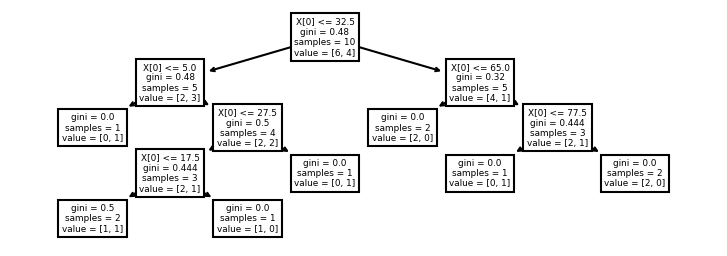

In [74]:
plt.figure(figsize=(6, 2), dpi=150)
tree.plot_tree(clf)

那么根据上述结果，如果需要对income进行三类分箱的话，则可以选择32.5和65作为切分点，对数据集进行切分：

<center><img src="https://i.loli.net/2021/11/14/2hDALcWroUBjaFK.png" alt="image-20211114165526044" style="zoom:33%;" />

&emsp;&emsp;不难发现，这种有监督的分箱的结果其实会极大程度利于有监督模型的构建（例如如果按照上述规则进行分箱，则不会影响决策树前两层的生长）。但有监督的分箱过程其实也会面临诸如可能泄露数据集标签信息从而造成过拟合、决策树生长过程不稳定、树模型容易过拟合等问题影响。因此，一般来说有监督的分箱可能会在一些特殊场景下采用一些变种的方式来进行，例如在推荐系统中常用的GBDT+LR模型组合中，就会采用一种非常特殊的方式对连续变量进行分箱：假设我们采用训练集中所有连续变量及标签训练两颗决策树，第一棵树有3个叶节点，第二棵树有2个叶节点，假设某条样本在第一棵树的第二个叶节点中、出现在第二棵树的第二个叶结点中，则我们可以将该样本标记为01001，其中总共5位数表示总共5个叶节点，而0表示该样本未出现在该位置上、1表示出现在该位置上，并最终将01001代替该样本的所有连续变量的取值，在每条样本都采用了该方式重编码后，我们就能完整使用新生成的这5列替换原数据集中所有连续变量。

<center><img src="https://i.loli.net/2021/11/14/QYCg1LKtIU3N4Bf.png" alt="image-20211114231113201" style="zoom:50%;" />

需要知道的是，这种编码方式并没有在sklearn中集成，很多过程需要手写算法或调用其他库，后续在遇到时再进行具体实现方面的介绍。

> 注意，这种根据标签对连续变量进行有监督的重编码的方式，有时也被称为目标编码，也是特征工程中特征衍生的一类重要方法，我们会在Part 3特征工程部分再进行讨论。

> 除了上述针对连续变量的特征变换方法外，还有一种能够对连续变量取对数的操作，能够让连续变量一定程度恢复正态分布的分布特性，进而提升模型效果。该方法实现过程较为简单，直接借助numpy中对数运算功能即可，例如np.log(income+1)对其进行转化即可（+1是为了防止0值出现），该方法有时会对部分线性模型起作用。

### 3.连续变量特征转化的ColumnTransformer集成

&emsp;&emsp;上述所介绍的关于连续变量的标准化或分箱等过程，也是可以集成到ColumnTransformer中的。例如，如果同时执行离散字段的多分类独热编码和连续字段的标准化，则可以创建如下转化流：

In [83]:
ColumnTransformer([
    ('cat', preprocessing.OneHotEncoder(drop='if_binary'), category_cols), 
    ('num', preprocessing.StandardScaler(), numeric_cols)
])

ColumnTransformer(transformers=[('cat', OneHotEncoder(drop='if_binary'),
                                 ['gender', 'SeniorCitizen', 'Partner',
                                  'Dependents', 'PhoneService', 'MultipleLines',
                                  'InternetService', 'OnlineSecurity',
                                  'OnlineBackup', 'DeviceProtection',
                                  'TechSupport', 'StreamingTV',
                                  'StreamingMovies', 'Contract',
                                  'PaperlessBilling', 'PaymentMethod']),
                                ('num', StandardScaler(),
                                 ['tenure', 'MonthlyCharges', 'TotalCharges'])])

类似的，如果需要同时对离散变量进行多分类独热编码、对连续字段进行基于kmeans的三分箱，则可以创建如下转化流：

In [84]:
ColumnTransformer([
    ('cat', preprocessing.OneHotEncoder(drop='if_binary'), category_cols), 
    ('num', preprocessing.KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans'), numeric_cols)
])

ColumnTransformer(transformers=[('cat', OneHotEncoder(drop='if_binary'),
                                 ['gender', 'SeniorCitizen', 'Partner',
                                  'Dependents', 'PhoneService', 'MultipleLines',
                                  'InternetService', 'OnlineSecurity',
                                  'OnlineBackup', 'DeviceProtection',
                                  'TechSupport', 'StreamingTV',
                                  'StreamingMovies', 'Contract',
                                  'PaperlessBilling', 'PaymentMethod']),
                                ('num',
                                 KBinsDiscretizer(encode='ordinal', n_bins=3,
                                                  strategy='kmeans'),
                                 ['tenure', 'MonthlyCharges', 'TotalCharges'])])

后续我们将基于这些高度自动化的转化流程，来进行离散变量和连续变量整体重编码。

## 三、逻辑回归模型训练与结果解释

&emsp;&emsp;在完成数据重编码后，接下来即可进行模型训练了，此处我们首先考虑构建可解释性较强的逻辑回归与决策树模型，并围绕最终模型输出结果进行结果解读，而在下一节，我们将继续介绍更多集成模型建模过程。

### 1.设置评估指标与测试集

&emsp;&emsp;当然，在模型训练开始前，我们需要设置模型结果评估指标。此处由于0：1类样本比例约为3：1，因此可以考虑使用准确率作为模型评估指标，同时参考混淆矩阵评估指标、f1-Score和roc-aux值。

&emsp;&emsp;需要知道的是，一般在二分类预测问题中，0：1在3：1左右是一个重要界限，若0：1小于3：1，则标签偏态基本可以忽略不计，不需要进行偏态样本处理（处理了也容易过拟合），同时在模型评估指标选取时也可以直接选择“中立”评估指标，如准确率或者roc-auc。而如果0：1大于3：1，则认为标签取值分布存在偏态，需要对其进行处理，如过采样、欠采样、或者模型组合训练、或者样本聚类等，并且如果此时需要重点衡量模型对1类识别能力的话，则更加推荐选择f1-Score。

&emsp;&emsp;当然，尽管此处数据集并未呈现明显偏态，但我们仍然会在后续介绍数据调整时介绍常用处理偏态数据的方法，不过还是需要强调的是，对偏态并不明显的数据集采用这些方法，极容易造成模型过拟合。

&emsp;&emsp;此外，模型训练过程我们也将模仿实际竞赛流程，即在模型训练开始之初就划分出一个确定的、全程不带入建模的测试集（竞赛中该数据集标签未知，只能通过在线提交结果后获得对应得分），而后续若要在模型训练阶段验证模型结果，则会额外在训练集中划分验证集。

In [13]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split

In [14]:
train, test = train_test_split(tcc, test_size=0.3, random_state=21)

其中train就是训练数据集，同时包含训练集的特征和标签。

In [211]:
tcc

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,0
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,0
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,0
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,1


### 2.逻辑回归模型训练

&emsp;&emsp;首先我们测试逻辑回归的建模效果。逻辑回归作为线性方程，连续变量和离散变量的数据解释是不同的，连续变量表示数值每变化1，对标签取值的影响，而分类变量则表示当该特征状态发生变化时，标签收到影响的程度。因此，对于若要带入离散变量进行逻辑回归建模，则需要对多分类离散变量进行独热编码处理。当然，也是因为我们需要先对数据集进行转化再进行训练，因此我们可以通过创建机器学习流来封装这两步。

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

- 数据转化

In [16]:
# 划分特征和标签
X_train = train.drop(columns=[ID_col, target]).copy()
y_train = train['Churn'].copy()
X_test = test.drop(columns=[ID_col, target]).copy()
y_test = test['Churn'].copy()

- 设置转化器与评估器

In [47]:
# 检验列是否划分完全
assert len(category_cols) + len(numeric_cols) == X_train.shape[1]

# 设置转化器流
logistic_pre = ColumnTransformer([
    ('cat', preprocessing.OneHotEncoder(drop='if_binary'), category_cols), 
    ('num', 'passthrough', numeric_cols)
])

# 实例化逻辑回归评估器
logistic_model = LogisticRegression(max_iter=int(1e8))

# 设置机器学习流
logistic_pipe = make_pipeline(logistic_pre, logistic_model)

- 模型训练

In [48]:
logistic_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                          

- 查看模型结果

&emsp;&emsp;接下来，我们直接通过.score方法查看模型再训练集和测试集上准确率：

In [49]:
logistic_pipe.score(X_train, y_train)

0.8089249492900609

In [50]:
logistic_pipe.score(X_test, y_test)

0.7931850449597728

当然，关于更多评估指标的计算，我们可以通过下述函数来实现，同时计算模型的召回率、精确度、f1-Score和roc-auc值：

In [22]:
def result_df(model, X_train, y_train, X_test, y_test, metrics=
              [accuracy_score, recall_score, precision_score, f1_score, roc_auc_score]):
    res_train = []
    res_test = []
    col_name = []
    for fun in metrics:
        res_train.append(fun(model.predict(X_train), y_train))
        res_test.append(fun(model.predict(X_test), y_test)) 
        col_name.append(fun.__name__)
    idx_name = ['train_eval', 'test_eval']
    res = pd.DataFrame([res_train, res_test], columns=col_name, index=idx_name)
    return res

In [102]:
result_df(logistic_pipe, X_train, y_train, X_test, y_test)

,accuracy_score,recall_score,precision_score,f1_score,roc_auc_score
train_eval,0.808925,0.669667,0.564064,0.612346,0.759552
test_eval,0.793185,0.615542,0.547273,0.579403,0.731108


&emsp;&emsp;一般来说准确率再80%以上的模型就算是可用的模型，但同时也要综合考虑当前数据集情况（建模难度），有些场景（比赛）下80%只是模型调优前的基准线（baseline），而有时候80%的准确率却是当前数据的预测巅峰结果（比赛Top 10）。所以对于上述结果的解读，即逻辑回归模型建模效果好或不好，可能需要进一步与其他模型进行横向对比来进行判断。

> 此外，需要注意的是，训练集和测试集的划分方式也会影响当前的输出结果，但建议是一旦划分完训练集和测试集后，就围绕当前建模结果进行优化，而不再考虑通过调整训练集和测试集的划分方式来影响最后输出结果，这么做也是毫无意义的。

### 2.逻辑回归的超参数调优

- 网格搜索优化

&emsp;&emsp;在模型训练完毕后，首先我们可以尝试一些基本优化方法——网格搜索，即超参数选择的调优，来尝试着对上述模型进行调优。网格搜索的过程并不一定能显著提高模型效果（当然其实也没有确定一定能提高模型效果的通用方法），但却是我们训练完模型后一定要做的基本优化流程，网格搜索能够帮我们确定一组最优超参数，并且随之附带的交叉验证的过程也能够让训练集上的模型得分更具有说服力。

In [21]:
from sklearn.model_selection import GridSearchCV

&emsp;&emsp;首先，逻辑回归评估器损失函数方程如下：

<center><img src="https://tva1.sinaimg.cn/large/008i3skNly1gs3v9h2gysj31gi0sy7bh.jpg" alt="1" style="zoom:33%;" />

而逻辑回归评估器的所有参数解释如下：

|参数|解释|
|:--:|:--:|    
|penalty|正则化项|   
|dual|是否求解对偶问题*|
|tol|迭代停止条件：两轮迭代损失值差值小于tol时，停止迭代|
|C|经验风险和结构风险在损失函数中的权重|
|fit_intercept|线性方程中是否包含截距项|
|intercept_scaling|相当于此前讨论的特征最后一列全为1的列，当使用liblinear求解参数时用于捕获截距|
|class_weight|各类样本权重*|
|random_state|随机数种子|
|solver|损失函数求解方法*|
|max_iter|求解参数时最大迭代次数，迭代过程满足max_iter或tol其一即停止迭代|
|multi_class|多分类问题时求解方法*|
|verbose|是否输出任务进程|
|warm_start|是否使用上次训练结果作为本次运行初始参数|
|l1_ratio|当采用弹性网正则化时，$l1$正则项权重，就是损失函数中的$\rho$|

&emsp;&emsp;而在这些所有超参数中，对模型结果影响较大的参数主要有两类，其一是正则化项的选择，同时也包括经验风险项的系数与损失求解方法选择，第二类则是迭代限制条件，主要是max_iter和tol两个参数，当然，在数据量较小、算力允许的情况下，我们也可以直接设置较大max_iter、同时设置较小tol数值。由于我们并未考虑带入数据本身的膨胀系数（共线性），因此此处我们优先考虑围绕经验风险系数与正则化选择类参数进行搜索与优化。

&emsp;&emsp;而整个网格搜索过程其实就是一个将所有参数可能的取值一一组合，然后计算每一种组合下模型在给定评估指标下的交叉验证的结果（验证集上的平均值），作为该参数组合的得分，然后通过横向比较（比较不同参数组合的得分），来选定最优参数组合。要使用网格搜索，首先我们需要设置参数空间，也就是带入哪些参数的哪些取值进行搜索。需要注意的是，由于我们现在是直接选用机器学习流进行训练，此时逻辑回归的超参数的名称会发生变化，我们可以通过机器学习流的.get_param来获取集成在机器学习流中的逻辑回归参数名称：

In [212]:
# 检验列是否划分完全
assert len(category_cols) + len(numeric_cols) == X_train.shape[1]

# 设置转化器流
logistic_pre = ColumnTransformer([
    ('cat', preprocessing.OneHotEncoder(drop='if_binary'), category_cols), 
    ('num', 'passthrough', numeric_cols)
])

# 实例化逻辑回归评估器
logistic_model = LogisticRegression(max_iter=int(1e8))

# 设置机器学习流
logistic_pipe = make_pipeline(logistic_pre, logistic_model)

In [213]:
logistic_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('cat', OneHotEncoder(drop='if_binary'),
                                    ['gender', 'SeniorCitizen', 'Partner',
                                     'Dependents', 'PhoneService', 'MultipleLines',
                                     'InternetService', 'OnlineSecurity',
                                     'OnlineBackup', 'DeviceProtection',
                                     'TechSupport', 'StreamingTV',
                                     'StreamingMovies', 'Contract',
                                     'PaperlessBilling', 'PaymentMethod']),
                                   ('num', 'passthrough',
                                    ['tenure', 'MonthlyCharges', 'TotalCharges'])])),
  ('logisticregression', LogisticRegression(max_iter=100000000))],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('cat', OneHotEncoder(drop='if_binary'),
                                

然后，我们选取正则化项、经验风险权重项C、弹性网正则化中l1正则化的比例项l1_ratio、以及求解器solver作为搜索超参数，来构建超参数空间：

In [106]:
logistic_param = [
    {'logisticregression__penalty': ['l1'], 'logisticregression__C': np.arange(0.1, 2.1, 0.1).tolist(), 'logisticregression__solver': ['saga']}, 
    {'logisticregression__penalty': ['l2'], 'logisticregression__C': np.arange(0.1, 2.1, 0.1).tolist(), 'logisticregression__solver': ['lbfgs', 'newton-cg', 'sag', 'saga']}, 
    {'logisticregression__penalty': ['elasticnet'], 'logisticregression__C': np.arange(0.1, 2.1, 0.1).tolist(), 'logisticregression__l1_ratio': np.arange(0.1, 1.1, 0.1).tolist(), 'logisticregression__solver': ['saga']}
]

接下来执行网格搜索，在网格搜索评估器的使用过程中，只需要输入搜索的评估器（也就是机器学习流）和评估器的参数空间即可，当然若想提高运行速度，可以在n_jobs中输入调用进程数，一般保守情况数值可以设置为当前电脑核数。此外，由于我们目前是以准确率作为评估指标，因此在实例化评估器时无需设置评估指标参数。

In [107]:
# 实例化网格搜索评估器
logistic_search = GridSearchCV(estimator = logistic_pipe,
                               param_grid = logistic_param,
                               n_jobs = 12)

In [28]:
import time

In [109]:
# 在训练集上进行训练
s = time.time()
logistic_search.fit(X_train, y_train)
print(time.time()-s, "s")

378.3900156021118 s


> 此处可以考虑拆分特征重编码和模型训练过程，可加快搜索效率

接下来查看在网格搜索中验证集的准确率的均值：

In [110]:
logistic_search.best_score_

0.8044624746450305

以及搜索出的最优超参数组合：

In [111]:
logistic_search.best_params_

{'logisticregression__C': 0.1,
 'logisticregression__penalty': 'l2',
 'logisticregression__solver': 'lbfgs'}

能够发现，搜索出来的参数结果和默认参数相差不大（默认情况下C的取值是1.0，其他没有区别），因此预计在这组最优参数下模型预测结果和默认参数差不多。

In [112]:
# 调用最佳参数的机器学习流评估器
logistic_search.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                          

In [113]:
# 计算预测结果
result_df(logistic_search.best_estimator_, X_train, y_train, X_test, y_test)

,accuracy_score,recall_score,precision_score,f1_score,roc_auc_score
train_eval,0.805477,0.667286,0.544352,0.599582,0.755672
test_eval,0.793185,0.619958,0.530909,0.571988,0.731416


需要注意的是，这里的网格搜索结果的.best_score_和训练集上准确率并不一致。我们需要清楚这里不一致的原因，以及当二者不一致时我们应该更相信哪个值。

&emsp;&emsp;首先是不一致的原因，需要知道的是，.best_score_返回的是在网格搜索的交叉验证过程中（默认是五折验证）验证集上准确率的平均值，而最终我们看到的训练集上准确率评分只是模型在训练集上一次运行后的整体结果，二者计算过程不一致，最终结果也自然是不一样的。

&emsp;&emsp;另外，如果二者不一致的话我们更应该相信哪个值呢？首先无论相信哪个值，最终的目的都是通过已知数据集上的模型得分，去判断模型当前的泛化能力，也就是去估计一下在未知数据集上模型的表现，哪个预估的更准，我们就应该更相信哪个。而对于上述两个取值，很明显经过交叉验证后的验证集平均得分更能衡量模型泛化能力，这也就是为何我们经常会发现经过交叉验证后的.best_score_会和测试集的评分更加接近的原因。

&emsp;&emsp;当然，更进一步的说，只要我们采用网格搜索来选取超参数，就默认我们更“相信”交叉验证后的结果（毕竟我们是根据这个平均得分选取超参数）。也就是说，在超参数选取的过程中，我们并没有其他选项。

&emsp;&emsp;**如果更深入的来探讨，实际上如何在训练集上获得一个更加可信的得分，其实是事关模型训练成败的关键。目前我们知道了交叉验证评分可信度>训练集上单次运行得分，而在Part 5时，我们还将更进一步寻找更加可信的得分，来训练泛化能力更强的模型。**

- f1-Score搜索

&emsp;&emsp;此外，在使用网格搜索的过程中，我们也能够规定搜索方向，即可规定超参数的调优方向。在默认情况下，搜索的目的是提升模型准确率，但我们也可以对其进行修改，例如希望搜索的结果尽可能提升模型f1-Score，则可在网格搜索实例化过程中调整scoring超参数。具体scoring参数可选列表如下：

<center><img src="https://tva1.sinaimg.cn/large/008i3skNly1gsffgu4xk0j31gy0py7cj.jpg" alt="1" style="zoom:30%;" /></center>

接下来执行模型训练与网格搜索过程：

In [131]:
# 设置转化器流
logistic_pre = ColumnTransformer([
    ('cat', preprocessing.OneHotEncoder(drop='if_binary'), category_cols), 
    ('num', 'passthrough', numeric_cols)
])

# 实例化逻辑回归评估器
logistic_model = LogisticRegression(max_iter=int(1e8))

# 设置机器学习流
logistic_pipe = make_pipeline(logistic_pre, logistic_model)

# 设置超参数空间
logistic_param = [
    {'logisticregression__penalty': ['l1'], 'logisticregression__C': np.arange(0.1, 2.1, 0.1).tolist(), 'logisticregression__solver': ['saga']}, 
    {'logisticregression__penalty': ['l2'], 'logisticregression__C': np.arange(0.1, 2.1, 0.1).tolist(), 'logisticregression__solver': ['lbfgs', 'newton-cg', 'sag', 'saga']}, 
    {'logisticregression__penalty': ['elasticnet'], 'logisticregression__C': np.arange(0.1, 2.1, 0.1).tolist(), 'logisticregression__l1_ratio': np.arange(0.1, 1.1, 0.1).tolist(), 'logisticregression__solver': ['saga']}
]

# 实例化网格搜索评估器
logistic_search_f1 = GridSearchCV(estimator = logistic_pipe,
                                  param_grid = logistic_param,
                                  scoring='f1',
                                  n_jobs = 12)

s = time.time()
logistic_search_f1.fit(X_train, y_train)
print(time.time()-s, "s")

384.4797456264496 s


In [134]:
logistic_search_f1.best_score_

0.6030911241536703

以及搜索出的最优超参数组合：

In [135]:
logistic_search_f1.best_params_

{'logisticregression__C': 1.4000000000000001,
 'logisticregression__penalty': 'l2',
 'logisticregression__solver': 'lbfgs'}

In [136]:
# 计算预测结果
result_df(logistic_search_f1.best_estimator_, X_train, y_train, X_test, y_test)

,accuracy_score,recall_score,precision_score,f1_score,roc_auc_score
train_eval,0.805882,0.667283,0.547384,0.601416,0.756069
test_eval,0.794605,0.621849,0.538182,0.576998,0.733343


能够发现，搜索出来的参数结果和此前围绕准确率指标的搜索结果略有不同，但对于最终测试集上的f1-Score提升效果并不明显，稍后我们会进一步介绍通过调整逻辑回归阈值来快速提升f1-Score。

- 更多超参数

&emsp;&emsp;当然，根据此前介绍，我们知道，对于逻辑回归来说，连续变量是存在多种可选的处理方式的，例如我们可以对其进行分箱或者归一化处理，这些不同的处理方法或许能提升模型最终效果。这里我们可以将其视作超参数，并一并纳入网格搜索调参的范围，来选取一种最佳的对连续变量的处理方式。同时，由于我们发现，在多次搜索过程中都未出现弹性网正则化的搜索结果，因此暂时将弹性网正则化的超参数从搜索空间中移除，以确保后续搜索的效率。

In [138]:
logistic_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('cat', OneHotEncoder(drop='if_binary'),
                                    ['gender', 'SeniorCitizen', 'Partner',
                                     'Dependents', 'PhoneService', 'MultipleLines',
                                     'InternetService', 'OnlineSecurity',
                                     'OnlineBackup', 'DeviceProtection',
                                     'TechSupport', 'StreamingTV',
                                     'StreamingMovies', 'Contract',
                                     'PaperlessBilling', 'PaymentMethod']),
                                   ('num', 'passthrough',
                                    ['tenure', 'MonthlyCharges', 'TotalCharges'])])),
  ('logisticregression', LogisticRegression(max_iter=100000000))],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('cat', OneHotEncoder(drop='if_binary'),
                                

In [140]:
# 设置转化器流
logistic_pre = ColumnTransformer([
    ('cat', preprocessing.OneHotEncoder(drop='if_binary'), category_cols), 
    ('num', 'passthrough', numeric_cols)
])

num_pre = ['passthrough', preprocessing.StandardScaler(), preprocessing.KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans')]

# 实例化逻辑回归评估器
logistic_model = LogisticRegression(max_iter=int(1e8))

# 设置机器学习流
logistic_pipe = make_pipeline(logistic_pre, logistic_model)

# 设置超参数空间
logistic_param = [
    {'columntransformer__num':num_pre, 'logisticregression__penalty': ['l1'], 'logisticregression__C': np.arange(0.1, 2.1, 0.1).tolist(), 'logisticregression__solver': ['saga']}, 
    {'columntransformer__num':num_pre, 'logisticregression__penalty': ['l2'], 'logisticregression__C': np.arange(0.1, 2.1, 0.1).tolist(), 'logisticregression__solver': ['lbfgs', 'newton-cg', 'sag', 'saga']}, 
]

# 实例化网格搜索评估器
logistic_search = GridSearchCV(estimator = logistic_pipe,
                                  param_grid = logistic_param,
                                  n_jobs = 12)

s = time.time()
logistic_search.fit(X_train, y_train)
print(time.time()-s, "s")

86.78103947639465 s


In [141]:
logistic_search.best_score_

0.8044624746450305

In [142]:
logistic_search.best_params_

{'columntransformer__num': 'passthrough',
 'logisticregression__C': 0.1,
 'logisticregression__penalty': 'l2',
 'logisticregression__solver': 'lbfgs'}

In [143]:
# 计算预测结果
result_df(logistic_search.best_estimator_, X_train, y_train, X_test, y_test)

,accuracy_score,recall_score,precision_score,f1_score,roc_auc_score
train_eval,0.805477,0.667286,0.544352,0.599582,0.755672
test_eval,0.793185,0.619958,0.530909,0.571988,0.731416


能够发现，根据交叉验证结果，模型仍然选择了最初搜索出来的参数组。

> 优化没效果，十之八九。

### 3.逻辑回归的进阶调优策略

&emsp;&emsp;尽管网格搜索是一种较为暴力的搜索最优参数的方法，但具体的搜索策略仍然举要结合当前模型与数据的实际情况来进行调整。例如对于逻辑回归来说，其实有个隐藏参数——类别判别阈值。通过对逻辑回归阈值的调整，能够直接影响最终的输出结果。此外，由于当前数据集存在一定程度样本不均衡问题，因此也可以通过调整class_weight参数来进行结果优化，不过需要注意的是，对于逻辑回归模型来说，很多时候阈值移动的效果是向下兼容class_weight的。

&emsp;&emsp;在sklearn中逻辑回归的判别阈值并不是超参数，因此如果需要对此进行搜索调优的话，我们可以考虑手动编写一个包装在逻辑回归评估器外层的评估器，并加入阈值这一超参数，然后再带入网格搜索流程；而clas_weight的搜索调优就相对简单，该参数作为逻辑回归评估器的原生参数，只需要合理设置参数空间对其搜索即可。

#### 3.1 阈值移动调优

- 自定义评估器

&emsp;&emsp;要手动编写sklearn评估器，需要先导入下述辅助构造sklearn评估器的包：

In [24]:
from sklearn.base import BaseEstimator, TransformerMixin

然后开始编写能够实现阈值移动的逻辑回归评估器：

In [158]:
LogisticRegression?

Init signature:
LogisticRegression(
    penalty='l2',
    *,
    dual=False,
    tol=0.0001,
    C=1.0,
    fit_intercept=True,
    intercept_scaling=1,
    class_weight=None,
    random_state=None,
    solver='lbfgs',
    max_iter=100,
    multi_class='auto',
    verbose=0,
    warm_start=False,
    n_jobs=None,
    l1_ratio=None,
)
Docstring:     
Logistic Regression (aka logit, MaxEnt) classifier.

In the multiclass case, the training algorithm uses the one-vs-rest (OvR)
scheme if the 'multi_class' option is set to 'ovr', and uses the
cross-entropy loss if the 'multi_class' option is set to 'multinomial'.
(Currently the 'multinomial' option is supported only by the 'lbfgs',
'sag', 'saga' and 'newton-cg' solvers.)

This class implements regularized logistic regression using the
'liblinear' library, 'newton-cg', 'sag', 'saga' and 'lbfgs' solvers. **Note
that regularization is applied by default**. It can handle both dense
and sparse input. Use C-ordered arrays or CSR matrices containi

In [74]:
class logit_threshold(BaseEstimator, TransformerMixin):
    
    def __init__(self, penalty='l2', C=1.0, max_iter=1e8, solver='lbfgs', l1_ratio=None, class_weight=None, thr=0.5):
        self.penalty = penalty
        self.C = C
        self.max_iter = max_iter
        self.solver = solver
        self.l1_ratio = l1_ratio
        self.thr = thr
        self.class_weight = class_weight
        
    def fit(self, X, y):
        clf = LogisticRegression(penalty = self.penalty, 
                                 C = self.C, 
                                 solver = self.solver, 
                                 l1_ratio = self.l1_ratio,
                                 class_weight=self.class_weight, 
                                 max_iter=self.max_iter)
        clf.fit(X, y)
        self.coef_ = clf.coef_
        self.clf = clf
        return self
        
    def predict(self, X):
        res = (self.clf.predict_proba(X)[:, 1]>=self.thr) * 1
        return res

&emsp;&emsp;需要注意的是，上述评估器只继承了部分逻辑回归评估器的核心参数，并且由于没有设置.score方法，因此如果要使用网格搜索调参，需要明确规定scoring参数。当然，在定义完评估器后，我们可以通过下述过程进行手动验证评估器的有效性：

In [75]:
# 创建数据集
np.random.seed(24)
X = np.random.normal(0, 1, size=(1000, 2))
y = np.array(X[:,0]+X[:, 1]**2 < 1.5, int)

In [76]:
clf = LogisticRegression()

In [77]:
clf.fit(X, y)

LogisticRegression()

In [78]:
# 输出阈值为0.4时的模型预测结果
res1 = (clf.predict_proba(X)[:, 1] >= 0.4) * 1

In [79]:
# 实例化自定义评估器，设置阈值为0.4
clf_thr = logit_threshold(thr=0.4)

In [80]:
clf_thr.fit(X, y)

logit_threshold(thr=0.4)

In [81]:
res2 = clf_thr.predict(X)

In [82]:
(res1 != res2).sum()

0

能够发现该评估器能够实现阈值调整。接下来，我们尝试带入阈值参数到搜索过程中，需要注意的是，阈值搜索对于f1-Score和roc-auc提升效果明显，一般来说对于准确率提升效果一般，因此我们考虑直接依据f1-Score分数进行搜索，以测试阈值调整的实际效果。

- 阈值搜索

In [146]:
# 设置转化器流
logistic_pre = ColumnTransformer([
    ('cat', preprocessing.OneHotEncoder(drop='if_binary'), category_cols), 
    ('num', 'passthrough', numeric_cols)
])

num_pre = ['passthrough', preprocessing.StandardScaler(), preprocessing.KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans')]

# 实例化逻辑回归评估器
logistic_model = logit_threshold(max_iter=int(1e8))

# 设置机器学习流
logistic_pipe = make_pipeline(logistic_pre, logistic_model)

# 设置超参数空间
logistic_param = [
    {'columntransformer__num':num_pre, 'logit_threshold__thr': np.arange(0.1, 1, 0.1).tolist(), 'logit_threshold__penalty': ['l1'], 'logit_threshold__C': np.arange(0.1, 1.1, 0.1).tolist(), 'logit_threshold__solver': ['saga']}, 
    {'columntransformer__num':num_pre, 'logit_threshold__thr': np.arange(0.1, 1, 0.1).tolist(), 'logit_threshold__penalty': ['l2'], 'logit_threshold__C': np.arange(0.1, 1.1, 0.1).tolist(), 'logit_threshold__solver': ['lbfgs', 'newton-cg', 'sag', 'saga']}, 
]

# 实例化网格搜索评估器
logistic_search_f1 = GridSearchCV(estimator = logistic_pipe,
                                  param_grid = logistic_param,
                                  scoring='f1',
                                  n_jobs = 12)

s = time.time()
logistic_search_f1.fit(X_train, y_train)
print(time.time()-s, "s")

369.4163067340851 s


In [147]:
logistic_search_f1.best_score_

0.6341624667020883

In [148]:
logistic_search_f1.best_params_

{'columntransformer__num': 'passthrough',
 'logit_threshold__C': 0.1,
 'logit_threshold__penalty': 'l2',
 'logit_threshold__solver': 'lbfgs',
 'logit_threshold__thr': 0.30000000000000004}

In [149]:
# 计算预测结果
result_df(logistic_search_f1.best_estimator_, X_train, y_train, X_test, y_test)

,accuracy_score,recall_score,precision_score,f1_score,roc_auc_score
train_eval,0.772617,0.554817,0.759666,0.641280,0.726672
test_eval,0.762423,0.531496,0.736364,0.617378,0.712084


能够发现，阈值移动对于模型的f1-Score提升效果显著，约提升了4%。

#### 3.2 class_weight调优

&emsp;&emsp;接下来，我们进一步调整class_weight参数。根据此前数据探索的结果我们知道，数据集中标签的0/1分布比例大致为3：1左右，而class_weight的核心作用在于能够调整不同类别样本在计算损失值时的权重，一般来说，如果是3:1的样本比例，class_weight的参数取值基本可以设置在2:1-4:1之间，当然也可以直接考虑使用不同类别样本数量的反比，也就是balanced参数。

In [26]:
y = tcc['Churn']
print(f'Percentage of Churn:  {round(y.value_counts(normalize=True)[1]*100,2)} %  --> ({y.value_counts()[1]} customer)\nPercentage of customer did not churn: {round(y.value_counts(normalize=True)[0]*100,2)}  %  --> ({y.value_counts()[0]} customer)')

Percentage of Churn:  26.54 %  --> (1869 customer)
Percentage of customer did not churn: 73.46  %  --> (5174 customer)


增加class_weight后的模型训练和调优过程：

In [29]:
# 设置转化器流
logistic_pre = ColumnTransformer([
    ('cat', preprocessing.OneHotEncoder(drop='if_binary'), category_cols), 
    ('num', 'passthrough', numeric_cols)
])

num_pre = ['passthrough', preprocessing.StandardScaler(), preprocessing.KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans')]

# 实例化逻辑回归评估器
logistic_model = logit_threshold(max_iter=int(1e8))

# 设置机器学习流
logistic_pipe = make_pipeline(logistic_pre, logistic_model)

# 设置超参数空间
cw_l = [None, 'balanced']
#cw_l.extend([{1: x} for x in np.arange(1, 4, 0.2)])
logistic_param = [
    {'columntransformer__num':num_pre, 'logit_threshold__thr': np.arange(0.1, 1, 0.1).tolist(), 'logit_threshold__penalty': ['l1'], 'logit_threshold__C': np.arange(0.1, 1.1, 0.1).tolist(), 'logit_threshold__solver': ['saga'], 'logit_threshold__class_weight':cw_l}, 
    {'columntransformer__num':num_pre, 'logit_threshold__thr': np.arange(0.1, 1, 0.1).tolist(), 'logit_threshold__penalty': ['l2'], 'logit_threshold__C': np.arange(0.1, 1.1, 0.1).tolist(), 'logit_threshold__solver': ['lbfgs', 'newton-cg', 'sag', 'saga'], 'logit_threshold__class_weight':cw_l}, 
]

# 实例化网格搜索评估器
logistic_search_f1 = GridSearchCV(estimator = logistic_pipe,
                                  param_grid = logistic_param,
                                  scoring='f1',
                                  n_jobs = 12)

s = time.time()
logistic_search_f1.fit(X_train, y_train)
print(time.time()-s, "s")

737.595550775528 s


In [31]:
logistic_search_f1.best_score_

0.6341624667020883

In [32]:
logistic_search_f1.best_params_

{'columntransformer__num': 'passthrough',
 'logit_threshold__C': 0.1,
 'logit_threshold__class_weight': None,
 'logit_threshold__penalty': 'l2',
 'logit_threshold__solver': 'lbfgs',
 'logit_threshold__thr': 0.30000000000000004}

In [33]:
# 计算预测结果
result_df(logistic_search_f1.best_estimator_, X_train, y_train, X_test, y_test)

,accuracy_score,recall_score,precision_score,f1_score,roc_auc_score
train_eval,0.772617,0.554817,0.759666,0.641280,0.726672
test_eval,0.762423,0.531496,0.736364,0.617378,0.712084


能够发现，阈值移动的效果会兼容class_weight参数调整结果。最后我们再来尝试围绕准确率进行搜索时二者参数的效果：

In [85]:
# 设置转化器流
logistic_pre = ColumnTransformer([
    ('cat', preprocessing.OneHotEncoder(drop='if_binary'), category_cols), 
    ('num', 'passthrough', numeric_cols)
])

num_pre = ['passthrough', preprocessing.StandardScaler(), preprocessing.KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans')]

# 实例化逻辑回归评估器
logistic_model = logit_threshold(max_iter=int(1e8))

# 设置机器学习流
logistic_pipe = make_pipeline(logistic_pre, logistic_model)

# 设置超参数空间
cw_l = [None, 'balanced']
#cw_l.extend([{1: x} for x in np.arange(1, 4, 0.2)])
logistic_param = [
    {'columntransformer__num':num_pre, 'logit_threshold__thr': np.arange(0.1, 1, 0.1).tolist(), 'logit_threshold__penalty': ['l1'], 'logit_threshold__C': np.arange(0.1, 1.1, 0.1).tolist(), 'logit_threshold__solver': ['saga'], 'logit_threshold__class_weight':cw_l}, 
    {'columntransformer__num':num_pre, 'logit_threshold__thr': np.arange(0.1, 1, 0.1).tolist(), 'logit_threshold__penalty': ['l2'], 'logit_threshold__C': np.arange(0.1, 1.1, 0.1).tolist(), 'logit_threshold__solver': ['lbfgs', 'newton-cg', 'sag', 'saga'], 'logit_threshold__class_weight':cw_l}, 
]

# 实例化网格搜索评估器
logistic_search = GridSearchCV(estimator = logistic_pipe,
                               param_grid = logistic_param,
                               scoring='accuracy',
                               n_jobs = 12)

s = time.time()
logistic_search.fit(X_train, y_train)
print(time.time()-s, "s")

# 计算预测结果
result_df(logistic_search.best_estimator_, X_train, y_train, X_test, y_test)

737.222731590271 s


,accuracy_score,recall_score,precision_score,f1_score,roc_auc_score
train_eval,0.808925,0.669973,0.563306,0.612026,0.759614
test_eval,0.793658,0.616803,0.547273,0.579961,0.731786


In [86]:
logistic_search.best_params_

{'columntransformer__num': 'passthrough',
 'logit_threshold__C': 0.30000000000000004,
 'logit_threshold__class_weight': None,
 'logit_threshold__penalty': 'l2',
 'logit_threshold__solver': 'lbfgs',
 'logit_threshold__thr': 0.5}

能够发现，在样本相对均衡、且以准确率作为调参目标进行搜索时，阈值移动和样本权重调整并未能对模型有更好效果提升。

#### 4.逻辑回归模型解释

&emsp;&emsp;对于逻辑回归的模型解释，核心是需要观察线性方程中自变量的系数，通过系数大小可以判断特征重要性，并且系数的具体数值也能表示因变量如何伴随自变量变化而变化。

- 逻辑回归方程系数查看

&emsp;&emsp;我们可以通过如下方式在一个训练好的网格搜索评估器中查看逻辑回归方程系数：

In [105]:
coe = logistic_search.best_estimator_.named_steps['logit_threshold'].coef_
coe = coe.flatten()
coe

array([-3.64734497e-02,  2.97225123e-01, -6.96677065e-02, -2.11536083e-01,
       -3.59041883e-01, -3.16598442e-01,  1.96605064e-01, -4.24434409e-02,
       -3.93451080e-01,  3.65505701e-01, -1.34491440e-01,  1.88033447e-01,
       -1.34491440e-01, -2.15978826e-01,  1.48635094e-02, -1.34491440e-01,
       -4.28088885e-02,  3.09582859e-02, -1.34491440e-01, -5.89036649e-02,
        1.53753023e-01, -1.34491440e-01, -1.81698402e-01, -1.31620667e-01,
       -1.34491440e-01,  1.03675288e-01, -1.14052749e-01, -1.34491440e-01,
        8.61073700e-02,  5.32238806e-01, -1.63533154e-01, -5.31142471e-01,
        3.89129562e-01, -9.62838286e-02, -1.82584235e-01,  2.82335761e-01,
       -1.65904515e-01, -6.68822855e-02,  1.00859554e-03,  3.84181240e-04])

而根据网格搜索评估器的结果，我们发现，上述数据输出结果实际上是经过了离散变量的多分类独热编码转化，因此我们可以借助此前定义的函数来生成具体特征含义：

In [98]:
# 我们带入的训练数据是DataFrame
# X_train

In [92]:
# 定位独热编码转化器
tf = logistic_search.best_estimator_.named_steps['columntransformer'].named_transformers_['cat']
tf

OneHotEncoder(drop='if_binary')

In [106]:
# 转化后离散变量列名称
category_cols_new = cate_colName(tf, category_cols)

# 所有字段名称
cols_new = category_cols_new + numeric_cols

# 查看特征名称数量和特征系数数量是否一致
assert len(cols_new) == len(coe)

In [107]:
# 创建index是列名称，取值是自变量系数的Series
weights = pd.Series(coe, index=cols_new)

In [108]:
weights

gender                                    -0.036473
SeniorCitizen                              0.297225
Partner                                   -0.069668
Dependents                                -0.211536
PhoneService                              -0.359042
MultipleLines_No                          -0.316598
MultipleLines_No phone service             0.196605
MultipleLines_Yes                         -0.042443
InternetService_DSL                       -0.393451
InternetService_Fiber optic                0.365506
InternetService_No                        -0.134491
OnlineSecurity_No                          0.188033
OnlineSecurity_No internet service        -0.134491
OnlineSecurity_Yes                        -0.215979
OnlineBackup_No                            0.014864
OnlineBackup_No internet service          -0.134491
OnlineBackup_Yes                          -0.042809
DeviceProtection_No                        0.030958
DeviceProtection_No internet service      -0.134491
DeviceProtec

然后可视化展示取值最大的10个自变量系数与取值最小的10个自变量系数：

<AxesSubplot:>

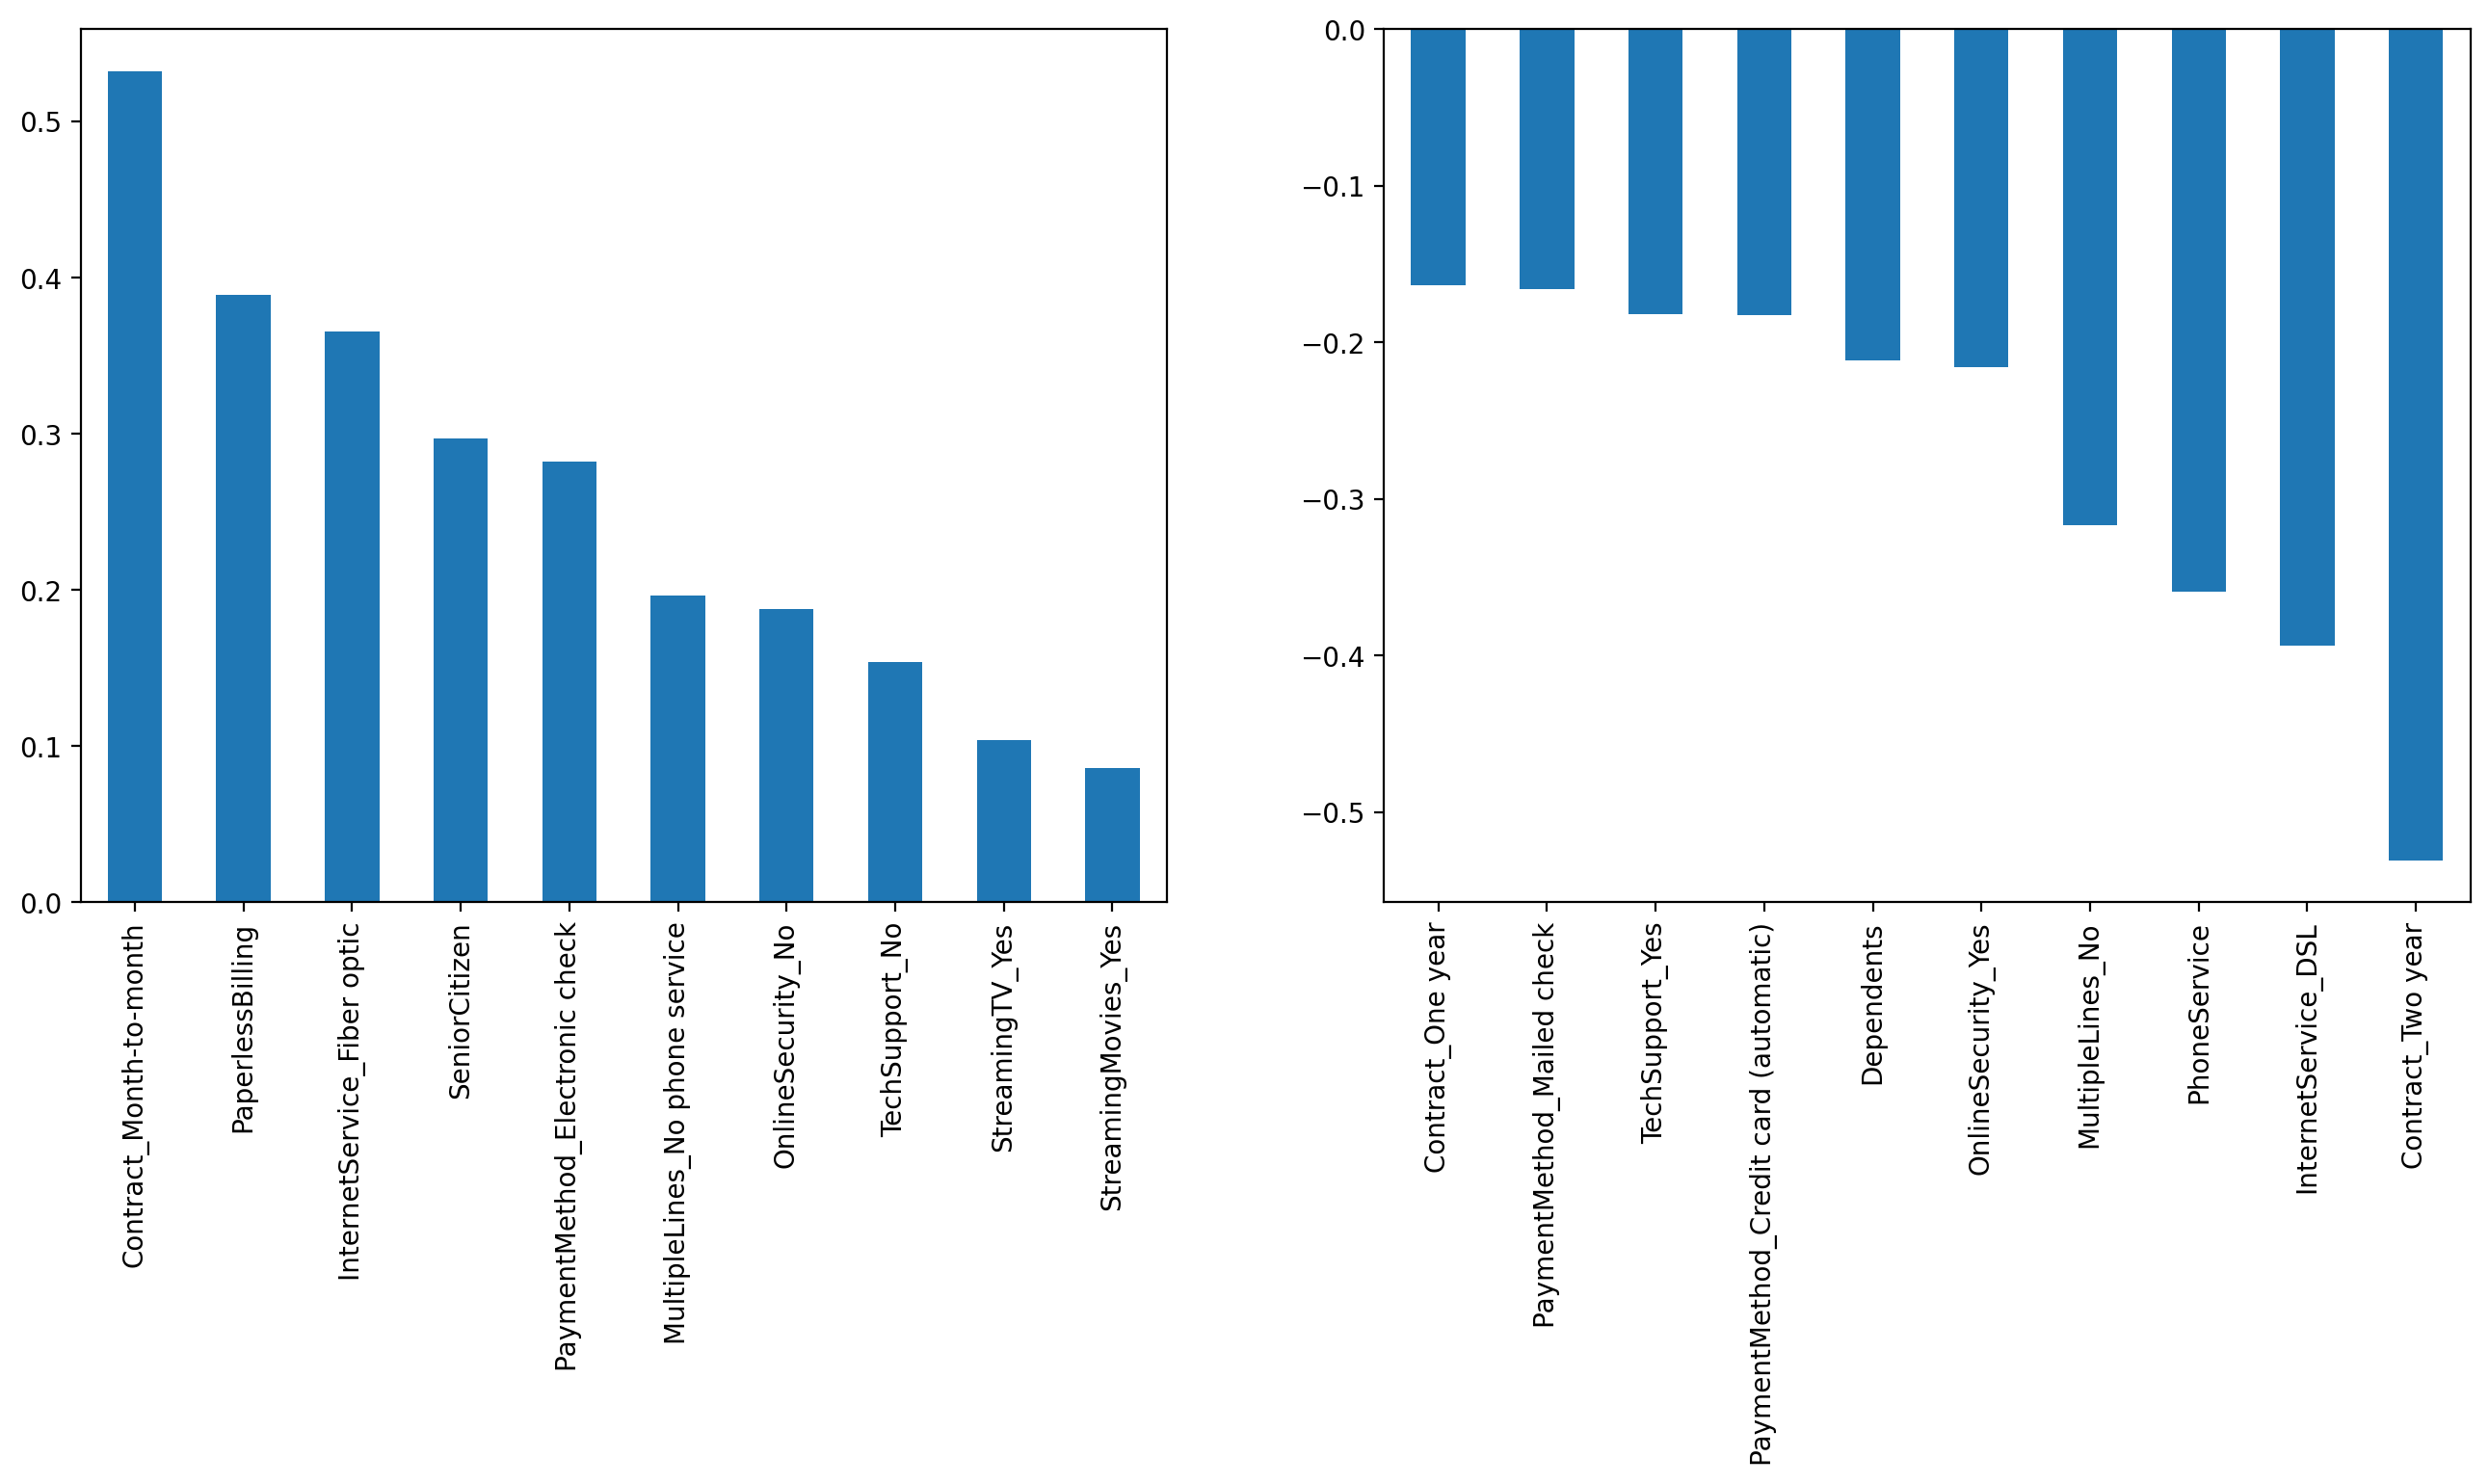

In [113]:
plt.figure(figsize=(16, 6), dpi=200)

# 挑选正相关的前10个变量
plt.subplot(121)
weights.sort_values(ascending = False)[:10].plot(kind='bar')

# 挑选负相关的前10个变量
plt.subplot(122)
weights.sort_values(ascending = False)[-10:].plot(kind='bar')

能够发现，Contract出现Month-to-month时，用户流失可能性较大，而Contract出现Two year时，用户留存可能性较大。当然，相比此前相关系数柱状图，上述根据模型生成的自变量系数可视化的结果会更加可靠一些，并且每个变量系数的取值也有对应的可解释的具体含义

- 自变量系数解释

&emsp;&emsp;接下来我们来进行逻辑回归模型方程系数解释。假设现在训练出来的逻辑回归线性方程为1-x，即逻辑回归方程模型如下：

$$y = \frac{1}{1+e^{-(1-x)}} $$

据此可以进一步推导出：

$$ln\frac{y}{1-y} = 1-x$$

此时，自变量x的系数为-1，据此可以解读为x每增加1，样本属于1的概率的对数几率就减少1。

&emsp;&emsp;而这种基于自变量系数的可解释性不仅可以用于自变量和因变量之间的解释，还可用于自变量重要性的判别当中，例如，假设逻辑回归方程如下：

$$ln\frac{y}{1-y} = x_1+2x_2-1$$

则可解读为$x_2$的重要性是$x_1$的两倍，$x_2$每增加1的效果（令样本为1的概率的增加）是$x_1$增加1效果的两倍。

&emsp;&emsp;据此，上述建模结果系数中，我们可以有如下解释，例如：对于Contract字段来说，Month-to-month出现时会让用户流失的对数几率增加50%（概率增加约10%），而Two year出现时会让用户流失的对数几率减少50%（概率减少约10%），其他变量也可参照该方式进行解释。

&emsp;&emsp;并且根据上述结果，我们不难看出，'Contract_Month-to-month'的系数是'SeniorCitizen'的两倍

In [125]:
weights['Contract_Month-to-month'], weights['SeniorCitizen']

(0.5322388059587707, 0.29722512309644633)

该结果说明，在导致用户流失的因素中，'Contract_Month-to-month'的影响是'SeniorCitizen'的两倍，或用户签订协约时出现月付行为所造成的用户流失风险，是用户是老年人导致的风险的两倍。

&emsp;&emsp;此外，需要注意的是，在上述建模过程中，我们发现连续变量的系数普遍较小：

In [129]:
weights[numeric_cols]

tenure           -0.066882
MonthlyCharges    0.001009
TotalCharges      0.000384
dtype: float64

其根本原因在于自变量取值范围较大，而逻辑回归方程系数实际上是在衡量自变量每增加1、因变量的对数几率变化情况，因此对于取值较大的连续变量来说，最终的系数结果较小。若想更加准确的和离散变量作比较，此处可以考虑将连续变量离散化，然后再计算离散化后的特征系数，并使用该系数和原离散变量系数进行比较，二者会有更好的可比性。

#### 5.逻辑回归建模总结

&emsp;&emsp;接下来，对逻辑回归建模过程以及模型使用技巧进行总结。

- 模型性能评估

&emsp;&emsp;通过上述尝试，我们基本能判断逻辑回归模型在当前数据集的性能，准确率约在80%左右，准确率没有太大的超参数调优搜索空间，而f1-Score则在我们额外设置的超参数——阈值上能够有更好的搜索结果。

- 超参数搜索策略总结

&emsp;&emsp;sklearn中的逻辑回归超参数众多，在算力允许的情况下，建议尽量设置更多的迭代次数（max_iter）和更小的收敛条件（tol），基本的搜索参数为正则化项（penalty）+经验风险系数（C）+求解器（solver），如果算力允许，可以纳入弹性网正则化项进行搜索，并搜索l1正则化项权重系数（l1_ratio）。若样本存在样本不均衡，可带入class_weight进行搜索，若搜索目标是提升f1-Score或ROC-AUC，则可通过自定义评估器进行阈值移动，若希望进行更加精确的搜索，可以纳入连续变量的编码方式进行搜索。

- 阈值移动与样本权重调优总结

&emsp;&emsp;根据上面的实验结果，对于阈值调优和样本权重调优可以进行如下总结：       
&emsp;&emsp;(1)阈值移动往往出现在f1-Score调优或ROC-AUC调优的场景中，由于阈值移动对召回率、精确度等指标调整效果显著，因此该参数的搜索往往效果要好于逻辑回归其他默认参数，类似的情况也出现在其他能够输出概率结果的模型中（如决策树、随机森林等）；      
&emsp;&emsp;(2)样本权重调节往往出现在非平衡类数据集的建模场景中，通过该参数的设置，能够让模型在训练过程中更加关注少数类样本，从而一定程度起到平衡数据集不同类别样本的目的，并且相比于其他平衡样本方法（例如过采样、欠采样、SMOTEENN等），该方法能够更好的避免过拟合，并且该参数同样也是一个通用参数，出现在sklearn集成的诸多模型中。建议如果算力允许，可以在任何指标调整过程中对该参数进行搜索；      
&emsp;&emsp;(3)不过如果是围绕f1-Score或ROC-AUC进行调优，阈值移动和样本权重调节会有功能上的重复，此时建议优先选用阈值进行搜索。

- 结果解读

&emsp;&emsp;对于逻辑回归来说，模型可解释性的核心在于模型是线性方程，据此我们可以根据线性方程中自变量的系数对其进行结果解读，包括自变量变化如何影响因变量，以及自变量之间的相对关系等。

## 四、决策树模型训练与结果解释

### 1.决策树模型训练

&emsp;&emsp;接下来，继续测试决策树模型。我们知道，由于决策树的分类边界更加灵活，相比只能进行线性边界划分的逻辑回归来来说，大多数情况下都能取得一个更好的预测结果。当然，对于决策树来说，由于并没有类似线性方程的数值解释，因此无需对分类变量进行独热编码转化，直接进行自然数转化即可

- 默认参数模型训练

In [130]:
# 导入决策树评估器
from sklearn.tree import DecisionTreeClassifier

# 设置转化器流
tree_pre = ColumnTransformer([
    ('cat', preprocessing.OrdinalEncoder(), category_cols), 
    ('num', 'passthrough', numeric_cols)
])

# 实例化决策树评估器
tree_model = DecisionTreeClassifier()

# 设置机器学习流
tree_pipe = make_pipeline(tree_pre, tree_model)

In [131]:
# 模型训练
tree_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat', OrdinalEncoder(),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                    

In [132]:
# 计算预测结果
result_df(tree_pipe, X_train, y_train, X_test, y_test)

,accuracy_score,recall_score,precision_score,f1_score,roc_auc_score
train_eval,0.998986,1.000000,0.996209,0.998101,0.999309
test_eval,0.743493,0.507143,0.516364,0.511712,0.667931


能够发现，模型严重过拟合，即在训练集上表现较好，但在测试集上表现一般。此时可以考虑进行网格搜索，通过交叉验证来降低模型结构风险。

### 2.决策树模型优化

&emsp;&emsp;决策树模型的参数解释如下：

|Name|Description|      
|:--:|:--:| 
|criterion|规则评估指标或损失函数，默认基尼系数，可选信息熵| 
|splitter|树模型生长方式，默认以损失函数取值减少最快方式生长，可选随机根据某条件进行划分|
|max_depth|树的最大生长深度，类似max_iter，即总共迭代几次| 
|min_samples_split|内部节点再划分所需最小样本数| 
|min_samples_leaf|叶节点包含最少样本数| 
|min_weight_fraction_leaf|叶节点所需最小权重和| 
|max_features|在进行切分时候最多带入多少个特征进行划分规则挑选|
|random_state|随机数种子| 
|max_leaf_nodes|叶节点最大个数| 
|min_impurity_decrease|数据集再划分至少需要降低的损失值| 
|min_impurity_split|数据集再划分所需最低不纯度，将在0.25版本中移除| 
|class_weight|各类样本权重| 
|presort|已在0.24版本中移除| 
|ccp_alpha|在执行CART树原生原理中的剪枝流程时结构复杂度惩罚因子的系数，默认情况下不使用该方法进行剪枝| 

一般来说，我们可以考虑树模型生长相关的参数来构造参数空间，当然，在新版sklearn中还加入了ccp_alpha参数，该参数是决策树的结构风险系数，作用和逻辑回归中C的作用类似，但二者取值正好相反（ccp_alpha是结构风险系数，而C是经验风险系数）。此处我们选取max_depth、min_samples_split、min_samples_leaf、max_leaf_nodes和ccp_alpha进行搜索：

$$
R_\alpha(T) = R(T) + \alpha|\widetilde{T}|
$$

In [216]:
# 设置转化器流
tree_pre = ColumnTransformer([
    ('cat', preprocessing.OrdinalEncoder(), category_cols), 
    ('num', 'passthrough', numeric_cols)
])

# 实例化决策树评估器
tree_model = DecisionTreeClassifier()

# 设置机器学习流
tree_pipe = make_pipeline(tree_pre, tree_model)

In [217]:
# tree_pipe.get_params()

In [218]:
# 构造包含阈值的参数空间
tree_param = {'decisiontreeclassifier__ccp_alpha': np.arange(0, 1, 0.1).tolist(),
              'decisiontreeclassifier__max_depth': np.arange(2, 8, 1).tolist(), 
              'decisiontreeclassifier__min_samples_split': np.arange(2, 5, 1).tolist(), 
              'decisiontreeclassifier__min_samples_leaf': np.arange(1, 4, 1).tolist(), 
              'decisiontreeclassifier__max_leaf_nodes':np.arange(6,10, 1).tolist()}

In [219]:
# 实例化网格搜索评估器
tree_search = GridSearchCV(estimator = tree_pipe,
                           param_grid = tree_param,
                           n_jobs = 12)

In [220]:
# 在训练集上进行训练
s = time.time()
tree_search.fit(X_train, y_train)
print(time.time()-s, "s")

30.371087312698364 s


能够发现决策树的训练效率要比逻辑回归高很多，接下来查看搜索结果：

In [138]:
# 查看验证集准确率均值
tree_search.best_score_

0.79026369168357

In [139]:
# 查看最优参数组
tree_search.best_params_

{'decisiontreeclassifier__ccp_alpha': 0.0,
 'decisiontreeclassifier__max_depth': 5,
 'decisiontreeclassifier__max_leaf_nodes': 8,
 'decisiontreeclassifier__min_samples_leaf': 1,
 'decisiontreeclassifier__min_samples_split': 2}

能够发现，决策树的最优参数都在设置的范围内。这里需要注意的是，如果某些参数的最优取值达到搜索空间的边界，则需要进一步扩大该参数的搜索范围。接下来查看经过网格搜索后的模型预测结果：

In [140]:
# 计算预测结果
result_df(tree_search.best_estimator_, X_train, y_train, X_test, y_test)

,accuracy_score,recall_score,precision_score,f1_score,roc_auc_score
train_eval,0.791278,0.645582,0.487491,0.555508,0.736874
test_eval,0.795078,0.648855,0.463636,0.540827,0.738672


能够发现，经过网格搜索和交叉验证后，决策树的过拟合问题已经的到解决，并且最终预测结果与逻辑回归类似。

&emsp;&emsp;需要知道的是，在大多数情况下，决策树的判别效力实际上是要强于逻辑回归（逻辑回归只能构建线性决策边界，而决策树可以构建折线决策边界），而此处决策树表现出了和逻辑回归类似的判别效力，则说明该数据集本身建模难度较大，极有可能是一个“上手容易、精通极难”的数据集。

> 在后面的建模过程中我们会陆续发现，诸多大杀四方的集成模型(XGB、LightGBM、CatBoost)在初始状态下也只能跑到80%准确率。

### 3.决策树模型解释

&emsp;&emsp;接下来进行决策树模型的模型解释，相比逻辑回归，树模型的模型解释会相对来说简单一些。树模型的模型解释主要有两点，其一是根据树模型的.feature_importances_属性来查看各个特征的重要性：

In [171]:
fi = tree_search.best_estimator_.named_steps['decisiontreeclassifier'].feature_importances_
fi

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.11262871, 0.15756862, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.5955054 , 0.        ,
       0.        , 0.10555534, 0.02874193, 0.        ])

> 需要注意的是，特征重要性为0表示该列特征并未在树模型生长过程中提供分支依据。

类似的，我们也可以以列名作为index、以特征重要性值作为数值，构建Series：

In [178]:
col_names = category_cols + numeric_cols

In [179]:
col_names

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'tenure',
 'MonthlyCharges',
 'TotalCharges']

In [180]:
feature_importances = pd.Series(fi, index=col_names)

In [181]:
feature_importances

gender              0.000000
SeniorCitizen       0.000000
Partner             0.000000
Dependents          0.000000
PhoneService        0.000000
MultipleLines       0.000000
InternetService     0.112629
OnlineSecurity      0.157569
OnlineBackup        0.000000
DeviceProtection    0.000000
TechSupport         0.000000
StreamingTV         0.000000
StreamingMovies     0.000000
Contract            0.595505
PaperlessBilling    0.000000
PaymentMethod       0.000000
tenure              0.105555
MonthlyCharges      0.028742
TotalCharges        0.000000
dtype: float64

然后查看5个重要性不为0的特征的对比分布：

<AxesSubplot:>

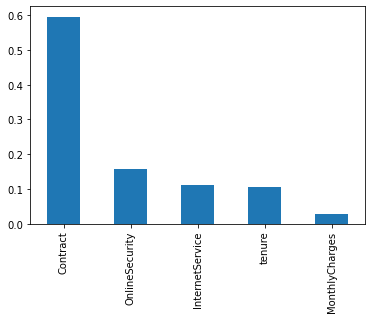

In [174]:
feature_importances.sort_values(ascending = False)[:5].plot(kind='bar')

&emsp;&emsp;当然，树模型的特征重要性只能给与一个直观的特征是否重要的感受，并不能像逻辑回归一样可以解释其数值的具体含义。此外需要注意的是，树模型的特征重要性的数值计算过程存在一定的随机性，也就是多次运行可能得到多组结果不同的特征重要性计算结果。因此很多时候树模型的特征重要性只能作为最终模型解释的参考。

> 若要精准的计算于解释特征重要性，可以考虑使用SHAP方法。此外，目前尚未接触到的一类特征重要性的用途是借助进行特征筛选，下一部分在讨论特征筛选时会具体讲解。

&emsp;&emsp;除了特征重要性以外，树模型还提供了非常直观的样本分类规则，并以树状图形式进行呈现。我们可以借助sklearn中数模块内的plot_tree函数来绘制树状图，并据此进一步提取有效的样本分类规则：

[Text(1578.1818181818182, 830.5, 'X[13] <= 0.5\ngini = 0.392\nsamples = 4930\nvalue = [3611, 1319]'),
 Text(1127.2727272727273, 679.5, 'X[7] <= 0.5\ngini = 0.491\nsamples = 2701\nvalue = [1535, 1166]'),
 Text(901.8181818181819, 528.5, 'X[16] <= 7.5\ngini = 0.499\nsamples = 1860\nvalue = [900, 960]'),
 Text(450.90909090909093, 377.5, 'X[6] <= 0.5\ngini = 0.454\nsamples = 751\nvalue = [262, 489]'),
 Text(225.45454545454547, 226.5, 'gini = 0.5\nsamples = 316\nvalue = [157, 159]'),
 Text(676.3636363636364, 226.5, 'gini = 0.366\nsamples = 435\nvalue = [105, 330]'),
 Text(1352.7272727272727, 377.5, 'X[6] <= 0.5\ngini = 0.489\nsamples = 1109\nvalue = [638, 471]'),
 Text(1127.2727272727273, 226.5, 'gini = 0.332\nsamples = 295\nvalue = [233, 62]'),
 Text(1578.1818181818182, 226.5, 'X[16] <= 16.5\ngini = 0.5\nsamples = 814\nvalue = [405, 409]'),
 Text(1352.7272727272727, 75.5, 'gini = 0.467\nsamples = 245\nvalue = [91, 154]'),
 Text(1803.6363636363637, 75.5, 'gini = 0.495\nsamples = 569\nvalue =

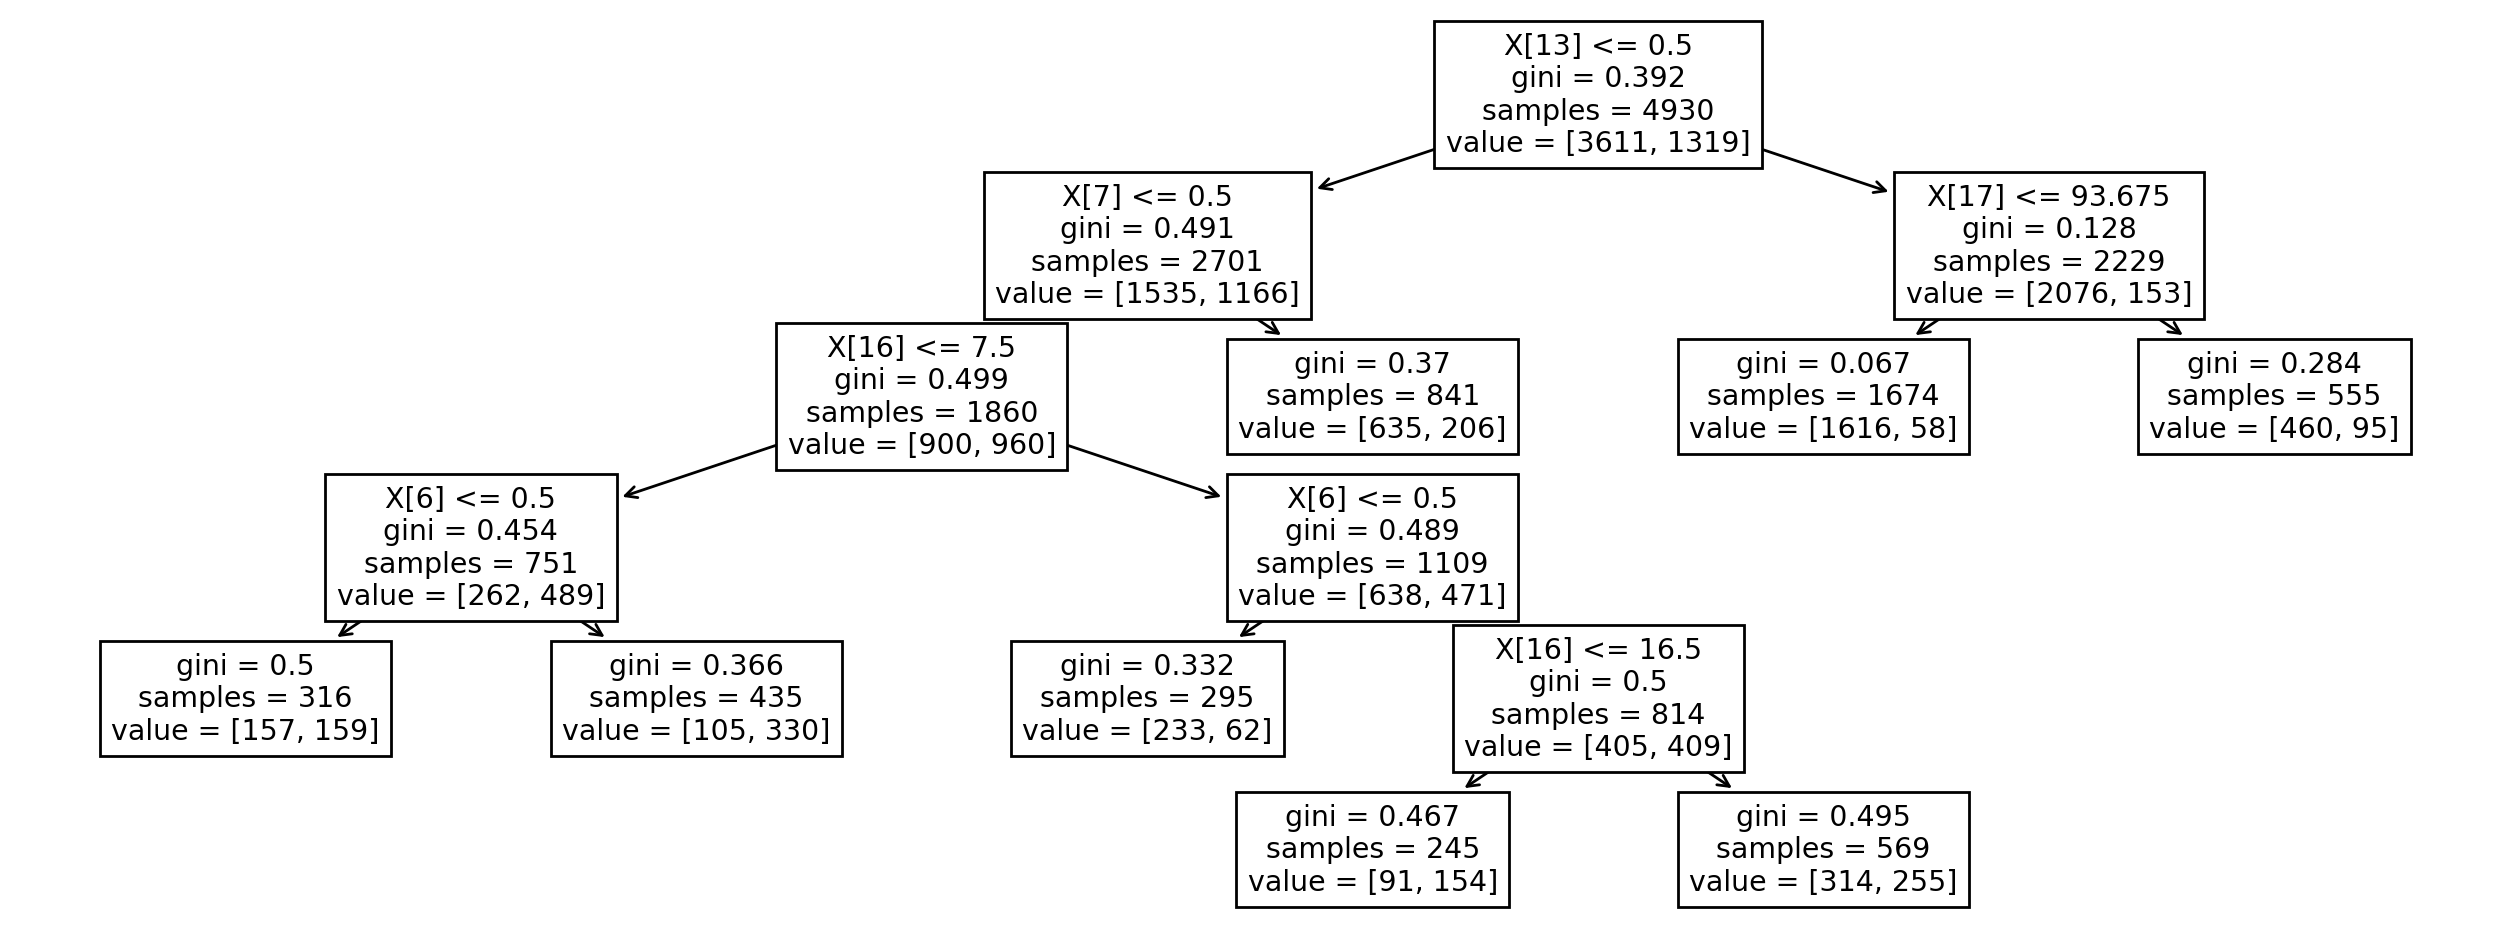

In [170]:
plt.figure(figsize=(16, 6), dpi=200)
tree.plot_tree(tree_search.best_estimator_.named_steps['decisiontreeclassifier'])

提取分类规则的过程是从叶节点往上进行提取，叶节点中的基尼系数代表当前数据集中样本标签的不纯度，越是有效的分类规则，对应的基尼系数越小，而样本数量越多，则说明该规则越有“普适性”。例如我们可以提取右侧分支的第三层左侧叶节点，该节点对应的分类规则可以解释为：X[13]不满足小于等于0.5时、且X[17]小于等于93.675时，在总共1674条样本中，只有58条样本是流失用户，约占比3%，说明满足该规则的用户大多都不会流失。

In [177]:
58/1674

0.03464755077658303

当然我们这里可以进一步查看X[13]和X[17]所代表的特征：

In [228]:
cat_rules = tree_search.best_estimator_.named_steps['columntransformer'].named_transformers_['cat'].categories_

In [235]:
cat_rules

[array(['Female', 'Male'], dtype=object),
 array([0, 1], dtype=int64),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'No phone service', 'Yes'], dtype=object),
 array(['DSL', 'Fiber optic', 'No'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['Month-to-month', 'One year', 'Two year'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['Bank transfer (automatic)', 'Credit card (automatic)',
        'Electronic check', 'Mailed check'], dtype=object)]

In [232]:
col_names[13], cat_rules[13]

('Contract', array(['Month-to-month', 'One year', 'Two year'], dtype=object))

In [234]:
col_names[17]

'MonthlyCharges'

也就是说，大多数非按月付费用户、并且月消费金额小于92.5的用户留存率较大。此外还有类似在按月付费用户中，未购买OnlineSecurity(X[7]<=0.5)、且入网不足8个月(X[16]<=7.5)、且购买了InternetService的用户，流失用户数量是留存用户数量的3倍。其他规则我们也可以通过树状图、按照类似方法进行提取，当然，树的层数越多，相关规则的说明就越复杂，同时也就越不利于进行解释。

In [210]:
(col_names[7], col_names[16], col_names[6])

('OnlineSecurity', 'tenure', 'InternetService')

&emsp;&emsp;当然，借助这些规则，我们其实可以进一步衍生一些业务指标（即衍生一些新的特征），例如付费形式和付费金额的交叉组合、购买服务和入网时间的交叉组合等。更多特征衍生策略，我们将在下一小节重点讲解。

&emsp;&emsp;至此，我们就完成了树模型的结果解释。